# Homework 7

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-13

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [46]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from scipy.optimize import minimize
from sklearn.decomposition import PCA

This homework relies on following symbology & data files, as of 2024-12-13.

USD cash bonds:
- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,

SOFR OIS swaps:
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

CDX Index:
- the CDX Index symbology file (for hyg basket) `cdx_symbology`,
- the CDX Index basket composition file `cdx_basket_composition`,


In [47]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

In [48]:
from scipy.stats import norm

def calc_d1_d2(A,r,sigma_A,T,K):
    d1 = (-np.log(K/A) + (r + 0.5 * sigma_A**2)* T ) / (sigma_A * np.sqrt(T))
    d2 = d1 - sigma_A * np.sqrt(T)
    return (d1, d2)

def fairValueEquity(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    E0  = A * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)
    return E0

def fairValueRiskyBond(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    B0  = A * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(d2)
    return B0

def defaultProbability(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)
    default_prob = norm.cdf(-d2)
    return default_prob

def survivalProbability(A,r,sigma_A,T,K):
    return(1 - defaultProbability(A,r,sigma_A,T,K))

def distanceToDefault(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)        
    return(d2)

def riskyBondYield(A,r,sigma_A,T,K):
    B0 = fairValueRiskyBond(A,r,sigma_A,T,K)
    bond_yield = - np.log(B0/K) / T       
    return bond_yield

def riskyBondCreditSpread(A,r,sigma_A,T,K):
    bond_yield = riskyBondYield(A,r,sigma_A,T,K)    
    bond_credit_spread = bond_yield - r
    return bond_credit_spread

def flatHazardRate(A,r,sigma_A,T,K):
    survival_prob = survivalProbability(A,r,sigma_A,T,K)
    flat_hazard_rate = - np.log(survival_prob) / T
    return flat_hazard_rate

def expectedRecoveryRate(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    exp_rec_rate = A / K * norm.cdf(-d1)/norm.cdf(-d2)
    return exp_rec_rate

def equityVolatility(A,r,sigma_A,T,K):
    d1, d2 = calc_d1_d2(A,r,sigma_A,T,K)    
    E0 = fairValueEquity(A,r,sigma_A,T,K)    
    sigma_E = (A / E0) * norm.cdf(d1) * sigma_A
    return sigma_E

-----------------------------------------------------------
# Problem 1: Pricing bonds in the Merton Structural Credit Model
## Follow Lecture 7, "Structural Credit Default Models"

## a. Company balance sheet metrics & fair value of equity
- Assets of $125 MM
- Liabilities of $100 MM face value, consisting of one zero coupon bond.
- Bond maturity is at T = 5 years
- Asset volatility at 20% (log-normal annualized vol)
- Flat risk-free interest rates of 4%

Compute the company Leverage, "Book Value of Equity" and fair value of equity metrics.


In [49]:
A = 125_000_000 # Asset
K = 100_000_000 # Liability
T = 5 # Maturity
sigma_A = 0.2 # Vol of Asset
r = 0.04 # Interest Rate

leverage = K / A  
book_value_equity = A  - K

print(f'Leverage: {leverage:.4f}')
print(f'Book Value of Equity: {book_value_equity:,.0f}')

# Fair Value of Equity
E0 = fairValueEquity(A,r,sigma_A,T,K)
print(f"Fair Value of Equity: {E0:,.0f}")

Leverage: 0.8000
Book Value of Equity: 25,000,000
Fair Value of Equity: 47,234,305


## b. Risky Bond Valuation (Fair Value of Liabilities)

Compute the fair value of the risky bond.

In [50]:
# Fair Value of Risky Bond
B0 = fairValueRiskyBond(A,r,sigma_A,T,K)
print(f"Fair Value of Risky Bond: {B0:,.0f}")

Fair Value of Risky Bond: 77,765,695


## c. Flat yield, spread and hazard rate

Compute the following credit risk metrics:
- Distance to Default
- Default Probability
- Bond Yield
- Bond Credit Spread
- Flat Hazard Rate
- Expected Recovery on Default

Plot separate charts for 
- Bond Credit Spreads and 
- Expected Recovery on Defaults

as a function of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

In [51]:
distance_to_default = distanceToDefault(A,r,sigma_A,T,K)
prob_default = defaultProbability(A,r,sigma_A,T,K)
prob_survival = survivalProbability(A,r,sigma_A,T,K)
bond_yield = riskyBondYield(A,r,sigma_A,T,K)
bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K)
flat_hazard_rate = flatHazardRate(A,r,sigma_A,T,K)
exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K)

print(f"Distance to Default: {distance_to_default:,.4f}")
print(f"Default Probability: {prob_default:,.4f}")
print(f"Survival Probability: {prob_survival:,.4f}")
print(f"Bond Yield: {bond_yield:,.4%}")
print(f"Credit Spread (bps): {bond_credit_spread*1e4:,.4f}")
print(f"Flat Hazard Rate (bps): {flat_hazard_rate*1e4:,.4f}")
print(f"Expected Recovery Rate: {exp_rec_rate:,.4%}")

Distance to Default: 0.7226
Default Probability: 0.2350
Survival Probability: 0.7650
Bond Yield: 5.0294%
Credit Spread (bps): 102.9396
Flat Hazard Rate (bps): 535.6851
Expected Recovery Rate: 64.3928%


In [52]:
# Arrange a Grid
step = 5_000_000
arrange_values = np.arange(50_000_000, 200_000_000 + step, step)

# List to store results
metrics = []

for asset in arrange_values:
    
    A = asset # Change the initial asset
    bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K)
    exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K)

    metrics.append({
        'Initial_Asset_Value': asset,
        'bond_credit_spread': bond_credit_spread,
        'exp_rec_rate': exp_rec_rate,
    })
    
df_metrics = pd.DataFrame(metrics)
# Comma separated values
# df_metrics['Initial_Asset_Value'] = df_metrics['Initial_Asset_Value'].apply(lambda x: f"{x:,.0f}")
display(df_metrics.head())
display(df_metrics.tail())

,Initial_Asset_Value,bond_credit_spread,exp_rec_rate
0,50000000,0.106466,0.446396
1,55000000,0.090883,0.473956
2,60000000,0.077589,0.498014
3,65000000,0.066249,0.519012
4,70000000,0.056577,0.537375


,Initial_Asset_Value,bond_credit_spread,exp_rec_rate
26,180000000,0.002056,0.683759
27,185000000,0.001785,0.686159
28,190000000,0.001552,0.688429
29,195000000,0.001351,0.690579
30,200000000,0.001176,0.692619


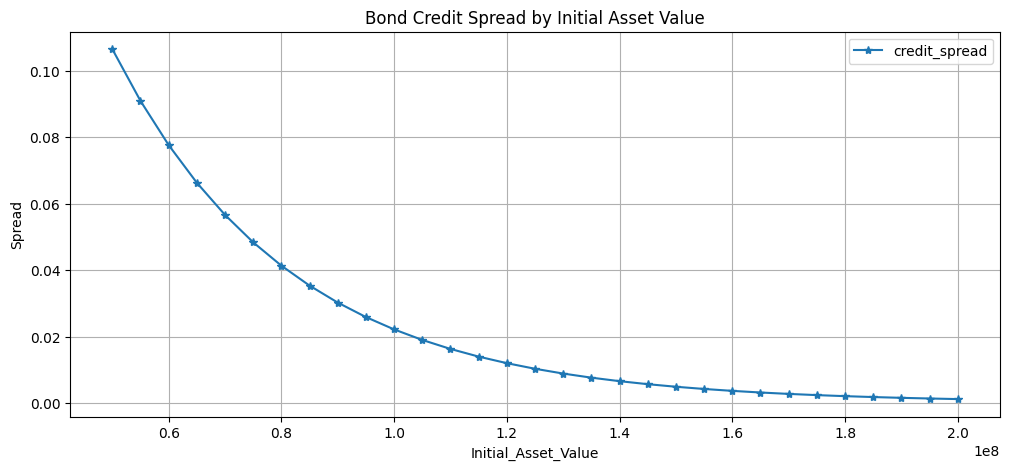

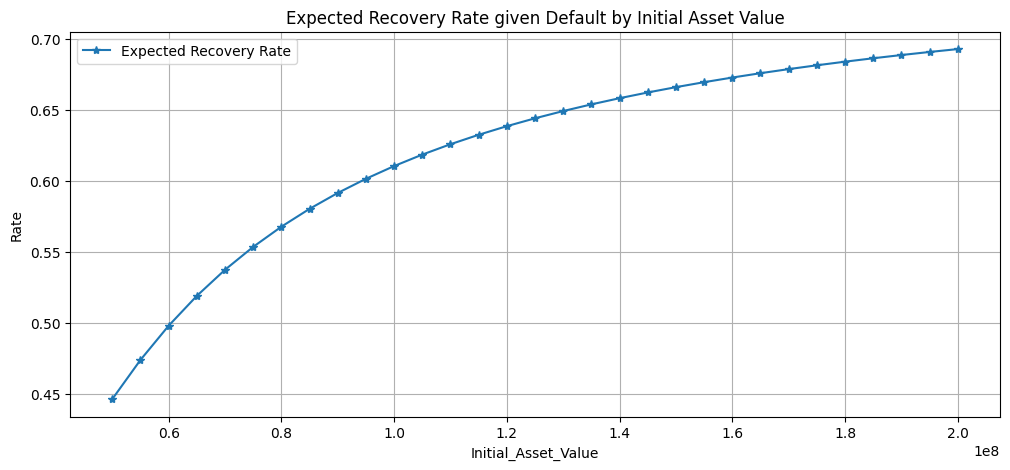

In [53]:
plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['bond_credit_spread'], '*-', label='credit_spread')
plt.title(f'Bond Credit Spread by Initial Asset Value')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Spread')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['exp_rec_rate'], '*-', label='Expected Recovery Rate')
plt.title(f'Expected Recovery Rate given Default by Initial Asset Value')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

## d. Equity volatility

Compute the Equity Volatility.

What happens to the equity volatility if initial Assets value goes up/down (as of time 0)?

Plot Equity Volatilities of initial Asset values, on a grid from $50 MM to $200 MM in steps of $5 MM.

 

In [54]:
# Arrange a Grid
step = 5_000_000
arrange_values = np.arange(50_000_000, 200_000_000 + step, step)

# List to store results
metrics = []

for asset in arrange_values:
    
    A = asset # Change the initial asset
    bond_credit_spread = riskyBondCreditSpread(A,r,sigma_A,T,K)
    exp_rec_rate = expectedRecoveryRate(A,r,sigma_A,T,K)
    sigma_E = equityVolatility(A,r,sigma_A,T,K)
    
    metrics.append({
        'Initial_Asset_Value': asset,
        'bond_credit_spread': bond_credit_spread,
        'exp_rec_rate': exp_rec_rate,
        'sigma_E': sigma_E,
    })
    
df_metrics = pd.DataFrame(metrics)
# Comma separated values
# df_metrics['Initial_Asset_Value'] = df_metrics['Initial_Asset_Value'].apply(lambda x: f"{x:,.0f}")
display(df_metrics.head())
display(df_metrics.tail())

,Initial_Asset_Value,bond_credit_spread,exp_rec_rate,sigma_E
0,50000000,0.106466,0.446396,0.987245
1,55000000,0.090883,0.473956,0.918834
2,60000000,0.077589,0.498014,0.858721
3,65000000,0.066249,0.519012,0.805566
4,70000000,0.056577,0.537375,0.758317


,Initial_Asset_Value,bond_credit_spread,exp_rec_rate,sigma_E
26,180000000,0.002056,0.683759,0.355196
27,185000000,0.001785,0.686159,0.349015
28,190000000,0.001552,0.688429,0.343244
29,195000000,0.001351,0.690579,0.337850
30,200000000,0.001176,0.692619,0.332802


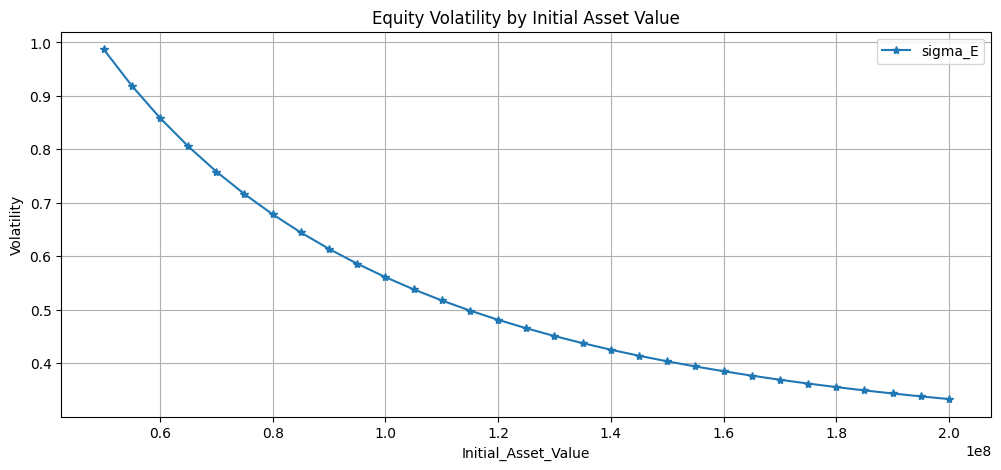

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(df_metrics['Initial_Asset_Value'], df_metrics['sigma_E'], '*-', label='sigma_E')
plt.title(f'Equity Volatility by Initial Asset Value')
plt.xlabel('Initial_Asset_Value')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

As initial asset value goes up, the equity volatility goes down. As companies start with bigger assets, they are more stable and thus, have lower volatility.

As initial asset value goes down, the equity volatility goes up. As companies start with smaller assets, they are riskier and thus, have higher volatility.

-----------------------------------------------------------
# Problem 2: LQD ETF basket analysis - bucketed interest rate hedging

## a. Load and explore the LQD basket composition and market data

Load the `lqd_basket_composition` Excel file into a dataframe. It contains the LQD basket constituent face notionals, weights and yields-to-maturities as of 2024-12-13.

Load the `lqd_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for LQD constituents.

How many corporate bonds are in the LQD basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the LQD basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [56]:
# Load LQD basket composition file, keep only columns needed for pricing
filepath_rawdata = f'./data/lqd_basket_composition.xlsx'
lqd_basket_comp = pd.read_excel(filepath_rawdata)
lqd_basket_comp = lqd_basket_comp[['isin', 'midYield', 'face_notional', 'face_notional_weight']]
display(lqd_basket_comp.head())

# lqd_corp_symbology
filepath_rawdata = f'./data/lqd_corp_symbology.xlsx'
lqd_corp_symbology = pd.read_excel(filepath_rawdata)
display(lqd_corp_symbology.head())

,isin,midYield,face_notional,face_notional_weight
0,US002824BG43,4.9585,12742000,0.039595
1,US002824BH26,5.2305,22618000,0.070283
2,US00774MBJ36,4.9410,9558000,0.029701
3,US023135AQ91,5.1095,15383000,0.047801
4,US023135CC87,5.2695,11914000,0.037022


,ticker,class,figi,isin,und_bench_tsy_isin,security,name,type,coupon,(No column name),...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,A,Corp,BBG00ZHZ78P4,US00846UAN19,US91282CLW90,A 2.3 03/12/31,AGILENT TECHNOLOGIES INC,GLOBAL,2.30,FIXED,...,2021-03-12,2021-09-12,2021-03-12,2031-03-12,CALLABLE,Sr Unsecured,850.0,US,USD,ACTV
1,AAPL,Corp,BBG01GKRFG36,US037833ET32,US91282CMA61,AAPL 4 05/10/28,APPLE INC,GLOBAL,4.00,FIXED,...,2023-05-10,2023-11-10,2023-05-10,2028-05-10,CALLABLE,Sr Unsecured,1500.0,US,USD,ACTV
2,AAPL,Corp,BBG011ZS1T38,US037833EH93,US91282CMA61,AAPL 1.4 08/05/28,APPLE INC,GLOBAL,1.40,FIXED,...,2021-08-05,2022-02-05,2021-08-05,2028-08-05,CALLABLE,Sr Unsecured,2300.0,US,USD,ACTV
3,AAPL,Corp,BBG0191F26Z0,US037833EN61,US91282CMA61,AAPL 3 1/4 08/08/29,APPLE INC,GLOBAL,3.25,FIXED,...,2022-08-08,2023-02-08,2022-08-08,2029-08-08,CALLABLE,Sr Unsecured,1000.0,US,USD,ACTV
4,AAPL,Corp,BBG00Q5L6G53,US037833DP29,US91282CMA61,AAPL 2.2 09/11/29,APPLE INC,GLOBAL,2.20,FIXED,...,2019-09-11,2020-03-11,2019-09-11,2029-09-11,CALLABLE,Sr Unsecured,1750.0,US,USD,ACTV


In [57]:
# Merge Data (on ISIN)
merged_lqd = pd.merge(lqd_basket_comp, lqd_corp_symbology, on=['isin'], how='inner')
display(merged_lqd[['ticker', 'isin', 'face_notional', 'midYield']].head())

,ticker,isin,face_notional,midYield
0,ABT,US002824BG43,12742000,4.9585
1,ABT,US002824BH26,22618000,5.2305
2,AER,US00774MBJ36,9558000,4.9410
3,AMZN,US023135AQ91,15383000,5.1095
4,AMZN,US023135CC87,11914000,5.2695


In [58]:
# Choose the dataframe
df = merged_lqd

face_notional_count = df['face_notional'].count()
face_notional_mean = df['face_notional'].mean()
face_notional_median = df['face_notional'].median()

print(f"Number of Corporate Bonds in the Basket: {face_notional_count:,.0f}")
print(f"Average Face Notional for a Bond: {face_notional_mean:,.0f}")
print(f"Median Face Notional for a Bond: {face_notional_median:,.0f}")

Number of Corporate Bonds in the Basket: 2,813
Average Face Notional for a Bond: 11,440,151
Median Face Notional for a Bond: 9,660,000


In [59]:
# Group by ticker, take the sum of notional per ticker
df = merged_lqd

df_grouped = df.groupby('ticker').agg({'face_notional': 'sum'})
display(df_grouped.head().style.format('{:,.0f}'.format))

# A ticker in the Basket
face_notional_count = df_grouped['face_notional'].count()
face_notional_mean = df_grouped['face_notional'].mean()
face_notional_median = df_grouped['face_notional'].median()

print('Number of Unique Tickers in the Basket:', len(df['ticker'].unique()))
print(f"Number of Unique Tickers in the Basket: {face_notional_count:,.0f}")
print(f"Average Face Notional for a Ticker: {face_notional_mean:,.0f}")
print(f"Median Face Notional for a Ticker: {face_notional_median:,.0f}")

,face_notional
ticker,
A,"3,559,000"
AAPL,"459,940,000"
ABBV,"370,011,000"
ABIBB,"317,327,000"
ABT,"35,360,000"


Number of Unique Tickers in the Basket: 408
Number of Unique Tickers in the Basket: 408
Average Face Notional for a Ticker: 78,875,353
Median Face Notional for a Ticker: 35,353,500


In [60]:
# Choose the dataframe
df = merged_lqd

ytm_mean = df['midYield'].mean()
ytm_median = df['midYield'].median()
ytm_std = df['midYield'].std()

print(f'For a bond in the Basket:')
print(f"Average yield-to-maturity: {ytm_mean:,.4f}")
print(f"Median yield-to-maturity: {ytm_median:,.4f}")
print(f"Standard Deviation of yield-to-maturity: {ytm_std:,.4f}")

For a bond in the Basket:
Average yield-to-maturity: 5.2822
Median yield-to-maturity: 5.2560
Standard Deviation of yield-to-maturity: 0.9273


## b. For each bond in the LQD basket, compute the bond DV01 and it's basket DV01 contribution

For each bond
* create the bond object,
* compute the analytic bond DV01 (from yield-to-maturity in the `lqd_basket_composition` dataframe),
* compute the DV01 on basket level (in $USD): basket_DV01 = bond_DV01 * face_notional / 10000

Add following columns to the LQD daframe and display the dataframe head:

| bond_DV01 | basket_DV01 | 
|----------|----------|



In [61]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)

metrics = []
bond_objects = []
bond_face_notional_weights = merged_lqd['face_notional_weight']
df_to_iterate = merged_lqd

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    bond_yield = row['midYield'] / 100 # From the YTM column
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
    
    bond_dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_DV01 = bond_dirty_price * bond_duration / 100
    basket_DV01 = bond_DV01 * row['face_notional'] / 10_000
     
    metrics.append({
        'dirty_price': bond_dirty_price,
        'bond_DV01': bond_DV01,
        'basket_DV01': basket_DV01,
    })
    bond_objects.append(bond)

df_metrics = pd.DataFrame(metrics)
display(df_metrics.head())

# Add to LQD Dataframe
merged_lqd['dirty_price'] = df_metrics['dirty_price']
merged_lqd['bond_DV01'] = df_metrics['bond_DV01']
merged_lqd['basket_DV01'] = df_metrics['basket_DV01']

display(merged_lqd[['ticker', 'figi', 'isin','und_bench_tsy_isin', 'face_notional', 'midYield',
                    'dirty_price', 'bond_DV01', 'basket_DV01']].head())

,dirty_price,bond_DV01,basket_DV01
0,98.345064,8.836348,11259.274031
1,95.930284,12.581430,28456.679098
2,102.660391,3.677515,3514.969163
3,98.167608,12.259842,18859.314876
4,67.748583,11.989352,14284.114175


,ticker,figi,isin,und_bench_tsy_isin,face_notional,midYield,dirty_price,bond_DV01,basket_DV01
0,ABT,BBG00FBCKY28,US002824BG43,US91282CLW90,12742000,4.9585,98.345064,8.836348,11259.274031
1,ABT,BBG00FBCKY37,US002824BH26,US912810UF39,22618000,5.2305,95.930284,12.581430,28456.679098
2,AER,BBG01KWNSJK4,US00774MBJ36,US91282CMA61,9558000,4.9410,102.660391,3.677515,3514.969163
3,AMZN,BBG007NHSDH4,US023135AQ91,US912810UF39,15383000,5.1095,98.167608,12.259842,18859.314876
4,AMZN,BBG010Z2TK09,US023135CC87,US912810UC08,11914000,5.2695,67.748583,11.989352,14284.114175


## c. Compute the analytical DV01s of the Benchmark US Treasuries

Use the `und_bench_tsy_isin` column in the bond symbology dataframe to find the Benchmark US Treasuries used for bucketed hedging in the LQD portfolio (there should be 7 of them).

Compute the analytic DV01 for each Benchmark US Treasury.


In [62]:
filepath_rawdata = f'./data/govt_on_the_run.xlsx'
df_govt = pd.read_excel(filepath_rawdata)
# r'[BC] Govt$' matches string that ends with B Govt or C Govt
# ~ negates the filter, showing rows that DO NOT match the filter (those that don't have BC)
# df_ontherun = df_govt[~df_govt['ticker'].str.contains(r'[BC] Govt$', regex=True)]

# Rename ISIN to und_bench_tsy_isin
# df_ontherun = df_ontherun.rename(columns={'isin' : 'und_bench_tsy_isin'})

# Grab every UST (Not just ontherun)
display(df_govt.head())

,ticker,date,figi,isin
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90
1,GT10B Govt,2024-12-13,BBG01P1YBJQ5,US91282CLF67
2,GT10C Govt,2024-12-13,BBG01MPC8VJ9,US91282CKQ32
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39


In [63]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Symbology + Market + UST
df_ust = pd.merge(df_merged_symbo_market, df_govt['isin'], on=['isin'], how='inner')
display(df_ust[['date', 'isin', 'figi', 'midPrice', 'midYield', 'TTM']].head())

,date,isin,figi,midPrice,midYield,TTM
0,2024-12-13,US91282CMB45,BBG01R4Z7Y32,99.37890,4.2225,3.003422
1,2024-12-13,US91282CLX73,BBG01QKHSKF0,99.71095,4.2300,2.921287
2,2024-12-13,US91282CLQ23,BBG01Q548T69,99.05470,4.2310,2.836413
3,2024-12-13,US91282CLY56,BBG01QZFYJV6,100.00390,4.2470,1.963039
4,2024-12-13,US91282CMA61,BBG01QZFYD58,99.44140,4.2510,4.963723


In [64]:
# Filter only the Treasuries used as underlying benchmark in the LQD Portfolio

# Step 1: Extract unique benchmark Treasury ISINs used in the LQD portfolio
underlying_treasuries = lqd_corp_symbology['und_bench_tsy_isin'].unique()
print(underlying_treasuries)

# Step 2: Filter df_govt to only Treasuries that are actually used in the LQD portfolio
matched_ontherun_treasuries = df_govt[df_govt['isin'].isin(underlying_treasuries)]
display(matched_ontherun_treasuries) # There should be 7

# Symbology + Market + UST in LQD
df_ust_in_lqd = pd.merge(df_ust, matched_ontherun_treasuries[['isin']], on=['isin'], how='inner')
display(df_ust_in_lqd[['ticker', 'security', 'isin', 'midPrice', 'midYield']])

['US91282CLW90' 'US91282CMA61' 'US912810UF39' 'US912810UC08'
 'US91282CLZ22' 'US91282CMB45' 'US91282CLY56']


,ticker,date,figi,isin
0,GT10 Govt,2024-12-13,BBG01QKHSMP5,US91282CLW90
3,GT2 Govt,2024-12-13,BBG01QZFYJV6,US91282CLY56
4,GT20 Govt,2024-12-13,BBG01QVTC1Y0,US912810UF39
9,GT3 Govt,2024-12-13,BBG01R4Z7Y32,US91282CMB45
11,GT30B Govt,2024-12-13,BBG01P1YBJY6,US912810UC08
15,GT5 Govt,2024-12-13,BBG01QZFYD58,US91282CMA61
18,GT7 Govt,2024-12-13,BBG01QZFYCF9,US91282CLZ22


,ticker,security,isin,midPrice,midYield
0,T,T 4 12/15/27,US91282CMB45,99.37890,4.2225
1,T,T 4 1/4 11/30/26,US91282CLY56,100.00390,4.2470
2,T,T 4 1/8 11/30/29,US91282CMA61,99.44140,4.2510
3,T,T 4 1/8 11/30/31,US91282CLZ22,98.80470,4.3255
4,T,T 4 1/4 11/15/34,US91282CLW90,98.82030,4.3980
5,T,T 4 1/4 08/15/54,US912810UC08,94.19535,4.6105
6,T,T 4 5/8 11/15/44,US912810UF39,99.26565,4.6820


In [88]:
metrics = []
bond_objects = []
df_to_iterate = df_ust_in_lqd

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    
    bond_yield = row['midYield'] / 100 # From the YTM column
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)
    
    bond_dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_DV01 = bond_dirty_price * bond_duration / 100
     
    metrics.append({
        'und_bench_tsy_DV01': bond_DV01,
    })
    bond_objects.append(bond)

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

# Add to df_ust_in_lqd Dataframe
df_ust_in_lqd['und_bench_tsy_DV01'] = df_metrics['und_bench_tsy_DV01']

# Rename columns
df_ust_in_lqd = df_ust_in_lqd.rename(columns={'security' : 'und_bench_tsy_security'})

# Drop und_bench_tsy_isin to avoid confusion
df_ust_in_lqd_filtered = df_ust_in_lqd.drop(columns='und_bench_tsy_isin')

# Rename isin to und_bench_tsy_isin because we should use the isin of UST
df_ust_in_lqd_filtered = df_ust_in_lqd_filtered.rename(columns={'isin': 'und_bench_tsy_isin'}).sort_values(by='und_bench_tsy_DV01')

display(df_ust_in_lqd_filtered[['und_bench_tsy_security', 'figi', 'und_bench_tsy_isin', 'midYield', 'und_bench_tsy_DV01']])

,und_bench_tsy_DV01
0,2.777391
1,1.858148
2,4.412158
3,5.910487
4,7.910222
5,15.407864
6,12.798670


,und_bench_tsy_security,figi,und_bench_tsy_isin,midYield,und_bench_tsy_DV01
1,T 4 1/4 11/30/26,BBG01QZFYJV6,US91282CLY56,4.2470,1.858148
0,T 4 12/15/27,BBG01R4Z7Y32,US91282CMB45,4.2225,2.777391
2,T 4 1/8 11/30/29,BBG01QZFYD58,US91282CMA61,4.2510,4.412158
3,T 4 1/8 11/30/31,BBG01QZFYCF9,US91282CLZ22,4.3255,5.910487
4,T 4 1/4 11/15/34,BBG01QKHSMP5,US91282CLW90,4.3980,7.910222
6,T 4 5/8 11/15/44,BBG01QVTC1Y0,US912810UF39,4.6820,12.798670
5,T 4 1/4 08/15/54,BBG01P1YBJY6,US912810UC08,4.6105,15.407864


## d. Compute the bucketed interest rate DV01s and hedging notionals in terms of Benchmark US Treasuries.

For each bond:
1. Identify the Benchmark US Treasury (via the `security` column) which will be used to hedge the interest rate exposure of the corporate bond.
2. Compute the IR hedge notional in the Benchmark US Treasury, using the ratio of corporate bond DV01 over Benchmark Treasury DV01.
3. Compute the IR hedge notional on basket level (in $USD)

Extend the LQD combined dataframe with the following columns:


| und_bench_tsy_security | und_bench_tsy_DV01 | und_bench_tsy_hedge_ratio | basket_hedge_notional |
|----------|-------------|-------|-------------|

where

- und_bench_tsy_security = Underlying Benchmark US Treasury `security` name
- und_bench_tsy_DV01 = Underlying Benchmark US Treasury DV01
- und_bench_tsy_hedge_ratio = bond_DV01 / und_bench_tsy_DV01
- basket_hedge_notional = face_notional * und_bench_tsy_hedge_ratio


In [66]:
# LQD Dataframe that has bond_DV01 and basket_DV01
display(merged_lqd[['security', 'isin','und_bench_tsy_isin', 'face_notional', 'midYield',
                    'dirty_price', 'bond_DV01', 'basket_DV01']].head())

,security,isin,und_bench_tsy_isin,face_notional,midYield,dirty_price,bond_DV01,basket_DV01
0,ABT 4 3/4 11/30/36,US002824BG43,US91282CLW90,12742000,4.9585,98.345064,8.836348,11259.274031
1,ABT 4.9 11/30/46,US002824BH26,US912810UF39,22618000,5.2305,95.930284,12.581430,28456.679098
2,AER 5.1 01/19/29,US00774MBJ36,US91282CMA61,9558000,4.9410,102.660391,3.677515,3514.969163
3,AMZN 4.95 12/05/44,US023135AQ91,US912810UF39,15383000,5.1095,98.167608,12.259842,18859.314876
4,AMZN 3 1/4 05/12/61,US023135CC87,US912810UC08,11914000,5.2695,67.748583,11.989352,14284.114175


In [67]:
# Merge with data on the underlying Treasuries
merged_lqd_2 = pd.merge(merged_lqd, df_ust_in_lqd_filtered[['und_bench_tsy_security', 'und_bench_tsy_isin', 'und_bench_tsy_DV01']], 
                        on=['und_bench_tsy_isin'], how='inner').sort_values(by='security')

display(merged_lqd_2[['security', 'isin','und_bench_tsy_isin', 'midYield',
                     'bond_DV01', 'basket_DV01', 'und_bench_tsy_security', 'und_bench_tsy_DV01']].head())

,security,isin,und_bench_tsy_isin,midYield,bond_DV01,basket_DV01,und_bench_tsy_security,und_bench_tsy_DV01
42,A 2.3 03/12/31,US00846UAN19,US91282CLW90,4.9935,4.857520,1728.791247,T 4 1/4 11/15/34,7.910222
578,AAPL 1 1/4 08/20/30,US037833DY36,US91282CMA61,4.4145,4.516557,4756.386219,T 4 1/8 11/30/29,4.412158
20,AAPL 1.4 08/05/28,US037833EH93,US91282CMA61,4.4125,3.127953,7657.854875,T 4 1/8 11/30/29,4.412158
717,AAPL 1.65 02/08/31,US037833ED89,US91282CLW90,4.4955,4.846503,10839.688974,T 4 1/4 11/15/34,7.910222
60,AAPL 1.65 05/11/30,US037833DU14,US91282CMA61,4.4800,4.377927,6438.617493,T 4 1/8 11/30/29,4.412158


In [68]:
# As a checking, look at how many unique underlying UST
underlying_treasuries = merged_lqd_2['und_bench_tsy_isin'].unique()
underlying_treasuries_count = len(underlying_treasuries)
print(underlying_treasuries)
print(f"Number of Underlying UST: {underlying_treasuries_count}")

['US91282CLW90' 'US91282CMA61' 'US912810UF39' 'US912810UC08'
 'US91282CLZ22' 'US91282CMB45' 'US91282CLY56']
Number of Underlying UST: 7


In [69]:
# Hedge Ratio = Bond DV01 / Benchmark Treasury DV01
merged_lqd_2['und_bench_tsy_hedge_ratio'] = merged_lqd_2['bond_DV01'] / merged_lqd_2['und_bench_tsy_DV01']

# Basket Hedge Notional (USD) = Hedge Ratio x Face Notional
merged_lqd_2['basket_hedge_notional'] = merged_lqd_2['und_bench_tsy_hedge_ratio'] * merged_lqd_2['face_notional']

display(merged_lqd_2[['isin', 'und_bench_tsy_isin', 'face_notional',
                     'bond_DV01', 'basket_DV01', 'und_bench_tsy_security', 'und_bench_tsy_DV01', 'und_bench_tsy_hedge_ratio',
                     'basket_hedge_notional']].head())

,isin,und_bench_tsy_isin,face_notional,bond_DV01,basket_DV01,und_bench_tsy_security,und_bench_tsy_DV01,und_bench_tsy_hedge_ratio,basket_hedge_notional
42,US00846UAN19,US91282CLW90,3559000,4.857520,1728.791247,T 4 1/4 11/15/34,7.910222,0.614081,2.185515e+06
578,US037833DY36,US91282CMA61,10531000,4.516557,4756.386219,T 4 1/8 11/30/29,4.412158,1.023662,1.078018e+07
20,US037833EH93,US91282CMA61,24482000,3.127953,7657.854875,T 4 1/8 11/30/29,4.412158,0.708940,1.735626e+07
717,US037833ED89,US91282CLW90,22366000,4.846503,10839.688974,T 4 1/4 11/15/34,7.910222,0.612689,1.370339e+07
60,US037833DU14,US91282CMA61,14707000,4.377927,6438.617493,T 4 1/8 11/30/29,4.412158,0.992242,1.459290e+07


## e. Aggregate the LQD basket metrics by underlying benchmark US Treasury buckets

Aggregate the following LQD basket metrics by underlying Benchmark US Treasury (7 buckets):

* bond counts,
* face notional,
* basket DV01 risk 
* basket hedge notional
 

by the 7 Benchmark US Treasury buckets (use groupby `und_bench_tsy_isin`).

Display the aggregated LQD basket dataframe.


In [70]:
df = merged_lqd_2 # Choose the dataframe
df_grouped = df.groupby('und_bench_tsy_isin').agg({'isin' : 'count',
                                                   'face_notional': 'sum',
                                                   'basket_DV01': 'sum',
                                                   'basket_hedge_notional': 'sum',
})
df_grouped = df_grouped.rename(columns={'isin' : 'basket_count'})
display(df_grouped.style.format('{:,.0f}'.format))

,basket_count,face_notional,basket_DV01,basket_hedge_notional
und_bench_tsy_isin,,,,
US912810UC08,654,"7,750,697,000","9,383,819","6,090,279,102"
US912810UF39,422,"4,912,744,000","5,201,950","4,064,445,661"
US91282CLW90,855,"9,531,508,000","6,642,264","8,397,063,310"
US91282CLY56,3,"41,848,000","16,516","88,881,882"
US91282CLZ22,60,"525,612,000","293,862","497,186,954"
US91282CMA61,816,"9,369,893,000","3,852,420","8,731,374,817"
US91282CMB45,3,"48,842,000","17,213","61,975,428"


## f. Display and plot the aggregated LQD basket dataframe

Merge the underlying benchmark treasury symbology and sort by benchmark treasury TTM to obtain the combined dataframe below:

| isin | security | TTM | basket_count | face_notional | basket_DV01 | basket_hedge_notional |
|----------|----------|----------|----------|----------|----------|----------|


Display the combined dataframe. Which US Treasury bucket contains the highest DV01 risk?

Create bar plots (using 'security' as x-axis) for following metrics:
* basket_count,
* basket_DV01 and
* face_notional + basket_hedge_notional.

In [71]:
# Aggregate Dataframe
df_agg = df_grouped.reset_index()
df_agg = df_agg.rename(columns={'und_bench_tsy_isin' : 'isin'})
# display(df_agg)

# Treasury Symbology + Market
# display(df_ust[['date', 'isin', 'security', 'figi', 'midPrice', 'midYield', 'TTM']].head())

# Aggregate + Symbology + Market
merged_agg = pd.merge(df_agg, df_ust[['isin', 'security', 'TTM']], on=['isin'], how='inner')
display(merged_agg)

,isin,basket_count,face_notional,basket_DV01,basket_hedge_notional,security,TTM
0,US912810UC08,654,7750697000,9.383819e+06,6.090279e+09,T 4 1/4 08/15/54,29.670089
1,US912810UF39,422,4912744000,5.201950e+06,4.064446e+09,T 4 5/8 11/15/44,19.923340
2,US91282CLW90,855,9531508000,6.642264e+06,8.397063e+09,T 4 1/4 11/15/34,9.921971
3,US91282CLY56,3,41848000,1.651557e+04,8.888188e+07,T 4 1/4 11/30/26,1.963039
4,US91282CLZ22,60,525612000,2.938617e+05,4.971870e+08,T 4 1/8 11/30/31,6.962355
5,US91282CMA61,816,9369893000,3.852420e+06,8.731375e+09,T 4 1/8 11/30/29,4.963723
6,US91282CMB45,3,48842000,1.721300e+04,6.197543e+07,T 4 12/15/27,3.003422


In [72]:
# Highest basket_DV01
basket_DV01_max_row = merged_agg['basket_DV01'].idxmax()
basket_DV01_max_isin = merged_agg.loc[basket_DV01_max_row, 'isin']
basket_DV01_max_security = merged_agg.loc[basket_DV01_max_row, 'security']
print(f'US Treasury bucket with the highest DV01 risk: {basket_DV01_max_isin}')
print(f'US Treasury bucket with the highest DV01 risk: {basket_DV01_max_security}')

US Treasury bucket with the highest DV01 risk: US912810UC08
US Treasury bucket with the highest DV01 risk: T 4 1/4 08/15/54


Which is the 30-year US Treasury bucket.

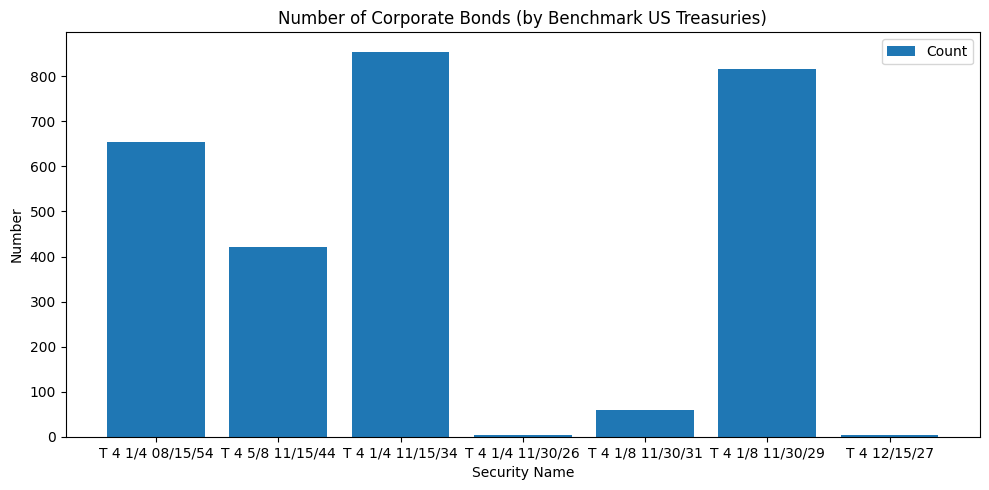

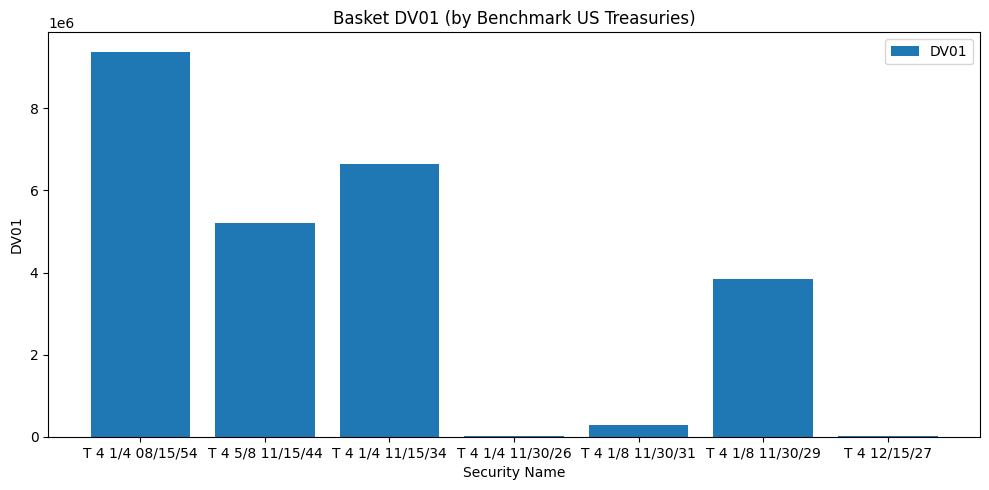

In [73]:
x_axis_values = merged_agg['security']
y_axis_values = merged_agg['basket_count']
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='Count')
plt.title('Number of Corporate Bonds (by Benchmark US Treasuries)')
plt.xlabel('Security Name')
plt.ylabel('Number')
plt.legend()
plt.tight_layout()
plt.show()

x_axis_values = merged_agg['security']
y_axis_values = merged_agg['basket_DV01']
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='DV01')
plt.title('Basket DV01 (by Benchmark US Treasuries)')
plt.xlabel('Security Name')
plt.ylabel('DV01')
plt.legend()
plt.tight_layout()
plt.show()

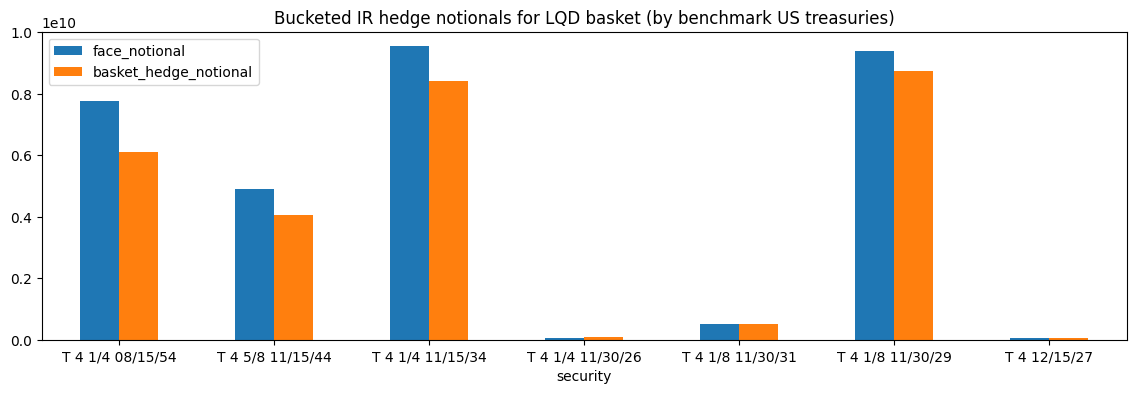

In [74]:
# Plotting 2 bar graphs
merged_agg.plot.bar(x='security', 
                    y=['face_notional', 'basket_hedge_notional'], 
                    rot=0, figsize=(14,4), title='Bucketed IR hedge notionals for LQD basket (by benchmark US treasuries)');

-----------------------------------------------------------
# Problem 3: CDS Intrinisc Index analysis on CDX IG 5Y


## a. Load and explore the CDX IG 5Y symbology, basket composition and market data

Load the `cdx_symbology` Excel file into a dataframe. Identify the CDX IG 5Y Series 43 index.

Load the `cdx_basket_composition` Excel file into a dataframe. It contains the CDX IG 5Y Series 43 basket composition and CDS Par Spread quotes as of 2024-12-13.

How many CDS contracts are in the CDX index basket? What are the contractual specs and weights of each CDS? Remember that each CDS is identical to the CDX index and the basket has uniform weights.

Compute mean, median and standard deviation of CDS Par Spreads in the basket.

Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.

In [75]:
# CDX Symbology Dataframe
filepath_rawdata = f'./data/cdx_symbology.xlsx'
cdx_symbology = pd.read_excel(filepath_rawdata)
# display(cdx_symbology.head())

# Filter only CDX IG 5Y Series 43 from the the Symbolody Dataframe
print("CDX IG 5Y Series 43 Index:")
cdx_ig_43 = cdx_symbology[cdx_symbology['ticker'] == 'CDXIG543']
display(cdx_ig_43.head())

# CDX Basket Composition
filepath_rawdata = f'./data/cdx_ig_43_5y_basket_composition.xlsx'
cdx_basket_comp = pd.read_excel(filepath_rawdata)
display(cdx_basket_comp.head())

CDX IG 5Y Series 43 Index:


,symbol,ticker,class,security,name,type,dcc,cpn_first,maturity,currency
8,CDX_CDXIG543,CDXIG543,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.43 12/29,CREDIT DEFAULT SWAP,ACT/360,2024-12-20,2029-12-20,USD


,date,index_symbol,index_ticker,index_series,index_weight,ticker,name,seniority,sector,implied_rating,currency,doc_clause,cds_coupon,cds_recovery,cds_par_spread_1y,cds_par_spread_2y,cds_par_spread_3y,cds_par_spread_5y,cds_par_spread_7y,cds_par_spread_10y
0,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,ALLYFI,Ally Finl Inc,SNRFOR,Financials,BB,USD,XR14,100,40,41.1778,66.6848,87.2987,132.0675,174.7143,188.8725
1,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMD,Advanced Micro Devices Inc,SNRFOR,Technology,A,USD,XR14,100,40,13.6814,18.5598,26.1149,37.3970,53.8446,70.1298
2,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMGN,Amgen Inc.,SNRFOR,Healthcare,A,USD,XR14,100,40,11.1293,18.1561,26.0495,41.3471,55.1754,70.5359
3,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,AMZN,Amazon Com Inc,SNRFOR,Consumer Services,AA,USD,XR14,100,40,9.8157,13.2599,16.5402,22.0839,31.2575,36.9580
4,2024-12-13,CDX_CDXIG543,CDX-NAIG,43,0.8,APA,APACHE CORP,SNRFOR,Energy,BB,USD,XR14,100,40,21.9683,37.9983,64.1039,108.1955,140.8867,155.8093


In [76]:
print('Number of CDS contracts in the CDX Index Basket:', len(cdx_basket_comp['ticker'].unique()))

print('\nContractual Specs and Weights:')
print('Index Weight (%):', (cdx_basket_comp['index_weight'][0]))
print('CDS Coupon Rate (bps):', (cdx_basket_comp['cds_coupon'][0]) )
print('CDS Recovery Rate (%):', (cdx_basket_comp['cds_recovery'][0]) )

Number of CDS contracts in the CDX Index Basket: 125

Contractual Specs and Weights:
Index Weight (%): 0.8
CDS Coupon Rate (bps): 100
CDS Recovery Rate (%): 40


In [77]:
df = cdx_basket_comp
year_list = [1, 2, 3, 5, 7, 10]

for year in year_list:
    cds_parspread_mean = df[f'cds_par_spread_{year}y'].mean()
    cds_parspread_median = df[f'cds_par_spread_{year}y'].median()
    cds_parspread_std = df[f'cds_par_spread_{year}y'].std()
    
    print(f'\nFor {year}Y CDS Par Spread:')
    print(f'Mean: {cds_parspread_mean:,.4f}')
    print(f'Median: {cds_parspread_median:,.4f}')
    print(f'Standard Deviation: {cds_parspread_std:,.4f}')


For 1Y CDS Par Spread:
Mean: 14.4761
Median: 12.4838
Standard Deviation: 7.2620

For 2Y CDS Par Spread:
Mean: 21.9841
Median: 19.2808
Standard Deviation: 11.3383

For 3Y CDS Par Spread:
Mean: 30.9469
Median: 26.1149
Standard Deviation: 15.6272

For 5Y CDS Par Spread:
Mean: 50.7063
Median: 42.1425
Standard Deviation: 26.0249

For 7Y CDS Par Spread:
Mean: 70.8846
Median: 62.0819
Standard Deviation: 33.8533

For 10Y CDS Par Spread:
Mean: 87.1555
Median: 79.0899
Standard Deviation: 36.0112


In [78]:
# Inputs
df = cdx_basket_comp
year_list = [1, 2, 3, 5, 7, 10]

# List to store results
metrics = []

for year in year_list:
    cds_parspread_mean = df[f'cds_par_spread_{year}y'].mean()
    cds_parspread_median = df[f'cds_par_spread_{year}y'].median()
    cds_parspread_std = df[f'cds_par_spread_{year}y'].std()

    metrics.append({
        'CDS_Par_Spread': f'{year}Y',
        'Mean': cds_parspread_mean,
        'Median': cds_parspread_median,
        'Standard_Deviation': cds_parspread_std,
    })
df_metrics = pd.DataFrame(metrics)
display(df_metrics)

,CDS_Par_Spread,Mean,Median,Standard_Deviation
0,1Y,14.476061,12.4838,7.261993
1,2Y,21.984126,19.2808,11.338286
2,3Y,30.946905,26.1149,15.627168
3,5Y,50.706338,42.1425,26.024877
4,7Y,70.884594,62.0819,33.853265
5,10Y,87.155538,79.0899,36.011243


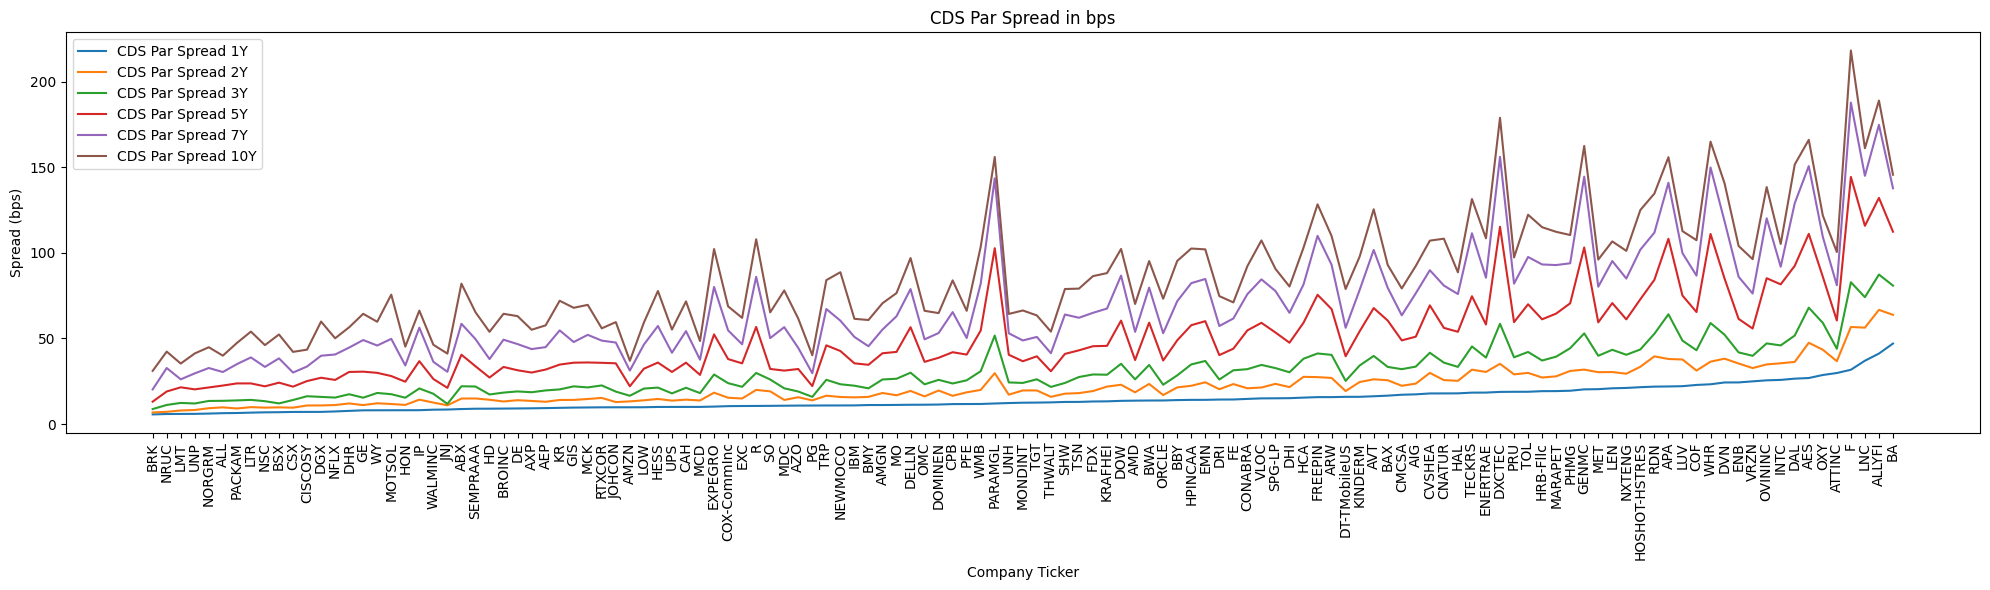

In [83]:
df = cdx_basket_comp
df_sorted = df.sort_values(by='cds_par_spread_1y')
year_list = [1, 2, 3, 5, 7, 10]

plt.figure(figsize=(20, 6))
for year in year_list: 
    plt.plot(df_sorted['ticker'], df_sorted[f'cds_par_spread_{year}y'], '-', label=f'CDS Par Spread {year}Y')
    
plt.title(f'CDS Par Spread in bps')
plt.xlabel('Company Ticker')
plt.ylabel('Spread (bps)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## b. Calibrate the US SOFR yield curve (via bootstrapping)
Load the `sofr_swap_symbology` Excel file into a dataframe.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe.

Follow Homework 4, Problem 2 and calibrate the SOFR discount curve as of 2024-12-13.

,date,figi,ticker,tenor,midRate,dcc
234,2024-12-13,BBG00KFWPJJ9,USOSFR1,1,4.19080,ACT/360
469,2024-12-13,BBG00KFWPJX3,USOSFR2,2,4.05545,ACT/360
704,2024-12-13,BBG00KFWPK15,USOSFR3,3,3.99135,ACT/360
939,2024-12-13,BBG00KFWPK51,USOSFR5,5,3.91570,ACT/360
1174,2024-12-13,BBG00KFWPK79,USOSFR7,7,3.89640,ACT/360
1409,2024-12-13,BBG00KFWPKB4,USOSFR10,10,3.90400,ACT/360
1643,2024-12-13,BBG00KFWPKF0,USOSFR20,20,3.92750,ACT/360
1878,2024-12-13,BBG00KFWPKH8,USOSFR30,30,3.76320,ACT/360


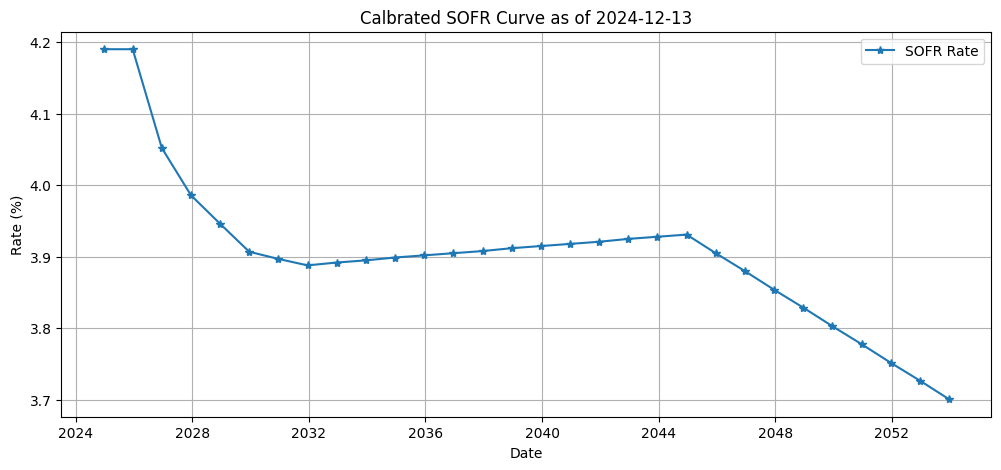

In [ ]:
# sofr_swaps_symbology Dataframe
filepath_rawdata = f'./data/sofr_swaps_symbology.xlsx'
sofr_swaps_symbology = pd.read_excel(filepath_rawdata)
# display(sofr_swaps_symbology)

# sofr_swaps_market_data_eod Dataframe
filepath_rawdata = f'./data/sofr_swaps_market_data_eod.xlsx'
sofr_swaps_market_data_eod = pd.read_excel(filepath_rawdata)

# Merge Data to give Tenor
sofr_combined = pd.merge(sofr_swaps_symbology, sofr_swaps_market_data_eod, on=['figi'], how='inner')

# Include only data from the as_of_date
sofr_combined = sofr_combined[sofr_combined['date'] == as_of_date]
display(sofr_combined[['date', 'figi', 'ticker', 'tenor', 'midRate','dcc']])

# sofr_yield_curve calibration

# Calibrating the Yield Curve
calc_date = calc_date
sofr_details =  sofr_combined
rate_quote_column = 'midRate' # Name of the Rate column

# Create SOFR Yield Curve
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_details, rate_quote_column)
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

# Display SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,1))]
sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid
#display(sofr_yield_curve_simple_df)
# display(sofr_yield_curve_details_df)

plt.figure(figsize=(12, 5))
plt.plot(sofr_yield_curve_details_df['Date'], sofr_yield_curve_details_df['ZeroRate'], '*-', label='SOFR Rate')
plt.title(f'Calbrated SOFR Curve as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid()
plt.show()

## c. Compute the intrinsic Premium Leg PV of the CDX index basket

Follow Homework 4, Problem 3. 

For each instrument in the basket, create the CDS object. 

Use the calibrated SOFR discount curve and the CDS Par Spreads to calibrate the individual hazard rate / survival probability curves.

Compute the Premium Leg PV for each CDS and aggregate the intrinsic Premium Leg PV of the basket (using basket weights).

Plot the Premium Leg PVs for individual CDS constituents.

In [121]:
# CDS Specs
side = ql.Protection.Seller
cds_recovery_rate = 0.4
cds_face_notional = 100
contractual_spread_bps = 100
cds_start_date = calc_date
cds_maturity_date = ql.Date(20,12, 2029)

# Create common CDS schedule
cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)

# Create common CDS object
cds_object = ql.CreditDefaultSwap(side, cds_face_notional, contractual_spread_bps / 10_000, cds_schedule, ql.Following, ql.Actual360())

# Weight of each CDS (use the shape of the Basket Composition dataframe)
cds_basket_weight = 1 / cdx_basket_comp.shape[0]
print(f'Weight of each CDS: {cds_basket_weight}')

Weight of each CDS: 0.008


In [120]:
# cds_par_spread_columns
cds_par_spread_columns = [f'cds_par_spread_{y}y' for y in [1, 2, 3, 5, 7, 10]]
# print(cds_par_spread_columns)

# List to store results
metrics = []
df_to_iterate = cdx_basket_comp
cdx_premium_leg_pv = 0
cdx_default_leg_pv = 0
cdx_pv = 0

for index, row in df_to_iterate.iterrows():
    
    # cds_par_spread_bps 
    cds_par_spreads_bps = list(row[cds_par_spread_columns])
    
    # Calibrate hazard_rate_curve
    hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_bps, cds_recovery_rate)
    
    # Create CDS Pricing Engine
    default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)
    cds_pricing_engine = ql.MidPointCdsEngine(default_prob_curve_handle, cds_recovery_rate, sofr_yield_curve_handle)
    
    # Set pricing_engine
    cds_object.setPricingEngine(cds_pricing_engine)

    # Calculate individual PVs
    cds_premium_leg_pv = cds_object.couponLegNPV()
    cds_default_leg_pv = cds_object.defaultLegNPV() * (-1)
    cds_pv = cds_object.NPV()

    # Intrinsic PV
    cdx_premium_leg_pv += cds_premium_leg_pv * cds_basket_weight
    cdx_default_leg_pv += cds_default_leg_pv * cds_basket_weight
    cdx_pv += cds_pv * cds_basket_weight

    metrics.append({
        'ticker': row['ticker'],
        'cds_premium_leg_pv': cds_premium_leg_pv,
        'cds_default_leg_pv': cds_default_leg_pv,
        'cds_pv': cds_pv,
    })

# Sort by Premium Leg
df_metrics = pd.DataFrame(metrics).sort_values(by='cds_premium_leg_pv')
display(df_metrics.head())

# Print CDX IG 5Y aggregated NAV results 
print(f'Intrinsic Premium Leg PV of the CDX Index Basket: {cdx_premium_leg_pv:,.2f}')
print(f'Intrinsic Default Leg PV of the CDX Index Basket: {cdx_default_leg_pv:,.2f}')
print(f'Intrinsic PV of the CDX Index Basket: {cdx_pv:,.2f}')

# CDX Par Spread = Spread (bps) x CDX Default Leg PV / CDX Premium Leg PV
cdx_par_spread_bps = contractual_spread_bps *  cdx_default_leg_pv / cdx_premium_leg_pv
print(f'CDX Par Spread: {cdx_par_spread_bps:,.2f}')

,ticker,cds_premium_leg_pv,cds_default_leg_pv,cds_pv
45,F,4.413000,6.356222,-1.943222
0,ALLYFI,4.415094,5.821036,-1.405942
10,BA,4.433709,4.971193,-0.537484
70,LNC,4.438941,5.129543,-0.690602
110,AES,4.450184,4.933716,-0.483533


Intrinsic Premium Leg PV of the CDX Index Basket: 4.53
Intrinsic Default Leg PV of the CDX Index Basket: 2.28
Intrinsic PV of the CDX Index Basket: 2.24
CDX Par Spread: 50.43


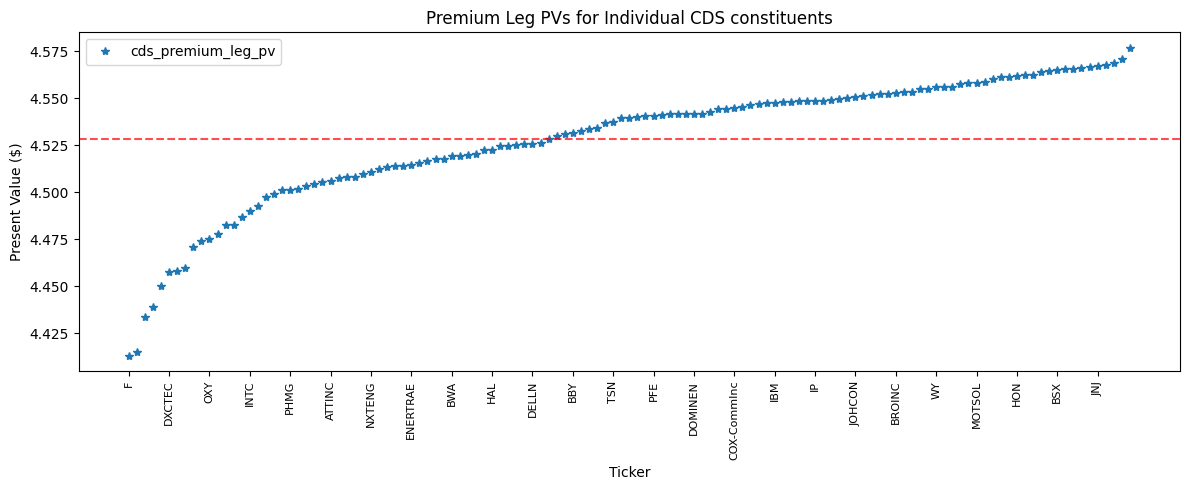

In [109]:
plt.figure(figsize=(12, 5))
plt.plot(df_metrics['ticker'], df_metrics['cds_premium_leg_pv'], '*', label='cds_premium_leg_pv')
plt.title('Premium Leg PVs for Individual CDS constituents')
plt.xlabel('Ticker')
plt.xticks(ticks=range(0, len(df), 5), labels=df_metrics['ticker'][::5], rotation=90, fontsize=8)
plt.ylabel('Present Value ($)')
plt.axhline(cdx_premium_leg_pv, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## d. Compute the intrinsic Default Leg PV of the CDX index basket

Compute the Default Leg PV for each CDS and determine the intrinsic Default Leg PV of the basket (using basket weights).

Plot the Default Leg PVs for individual CDS constituents.

,ticker,cds_premium_leg_pv,cds_default_leg_pv,cds_pv
14,BRK,4.576969,0.598652,3.978317
85,NRUC,4.570730,0.868446,3.702284
117,UNP,4.568890,0.924968,3.643922
63,JNJ,4.567232,0.964300,3.602931
84,NORGRM,4.566725,0.975406,3.591319


Intrinsic Premium Leg PV of the CDX Index Basket: 4.53
Intrinsic Default Leg PV of the CDX Index Basket: 2.28
Intrinsic PV of the CDX Index Basket: 2.24


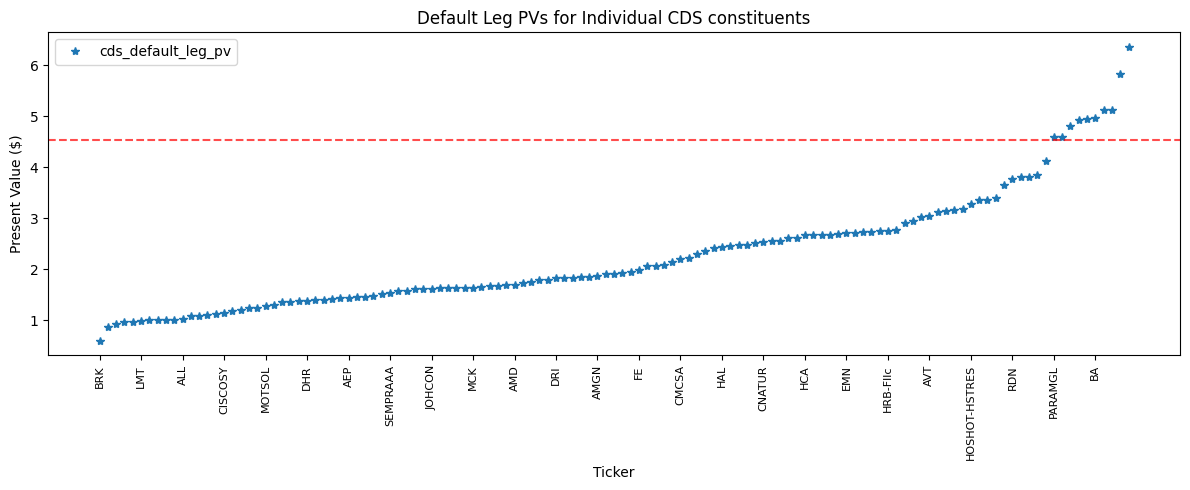

In [111]:
# Sort by Default Leg
df_metrics = pd.DataFrame(metrics).sort_values(by='cds_default_leg_pv')
display(df_metrics.head())

# Print CDX IG 5Y aggregated NAV results 
print(f'Intrinsic Premium Leg PV of the CDX Index Basket: {cdx_premium_leg_pv:,.2f}')
print(f'Intrinsic Default Leg PV of the CDX Index Basket: {cdx_default_leg_pv:,.2f}')
print(f'Intrinsic PV of the CDX Index Basket: {cdx_pv:,.2f}')

plt.figure(figsize=(12, 5))
plt.plot(df_metrics['ticker'], df_metrics['cds_default_leg_pv'], '*', label='cds_default_leg_pv')
plt.title('Default Leg PVs for Individual CDS constituents')
plt.xlabel('Ticker')
plt.xticks(ticks=range(0, len(df), 5), labels=df_metrics['ticker'][::5], rotation=90, fontsize=8)
plt.ylabel('Present Value ($)')
plt.axhline(cdx_premium_leg_pv, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## e. Compute the intrinsic PV and Par Spread of the CDX index basket

Compute the intrinsic index PV. 

Compute the CDX instrinsic index Par Spread (using ratio of CDX default vs premium legs).

For comparison, plot the CDS PVs for individual CDS constituents.

In [113]:
# Print CDX IG 5Y aggregated NAV results 
print(f'Intrinsic Premium Leg PV of the CDX Index Basket: {cdx_premium_leg_pv:,.2f}')
print(f'Intrinsic Default Leg PV of the CDX Index Basket: {cdx_default_leg_pv:,.2f}')
print(f'Intrinsic PV of the CDX Index Basket: {cdx_pv:,.2f}')

# CDX Par Spread = Spread (bps) x CDX Default Leg PV / CDX Premium Leg PV
cdx_par_spread_bps = contractual_spread_bps *  cdx_default_leg_pv / cdx_premium_leg_pv
print(f'CDX Par Spread: {cdx_par_spread_bps:,.2f}')

Intrinsic Premium Leg PV of the CDX Index Basket: 4.53
Intrinsic Default Leg PV of the CDX Index Basket: 2.28
Intrinsic PV of the CDX Index Basket: 2.24
CDX Par Spread: 50.43


,ticker,cds_premium_leg_pv,cds_default_leg_pv,cds_pv
45,F,4.413000,6.356222,-1.943222
0,ALLYFI,4.415094,5.821036,-1.405942
70,LNC,4.438941,5.129543,-0.690602
39,DXCTEC,4.457686,5.126638,-0.668952
10,BA,4.433709,4.971193,-0.537484


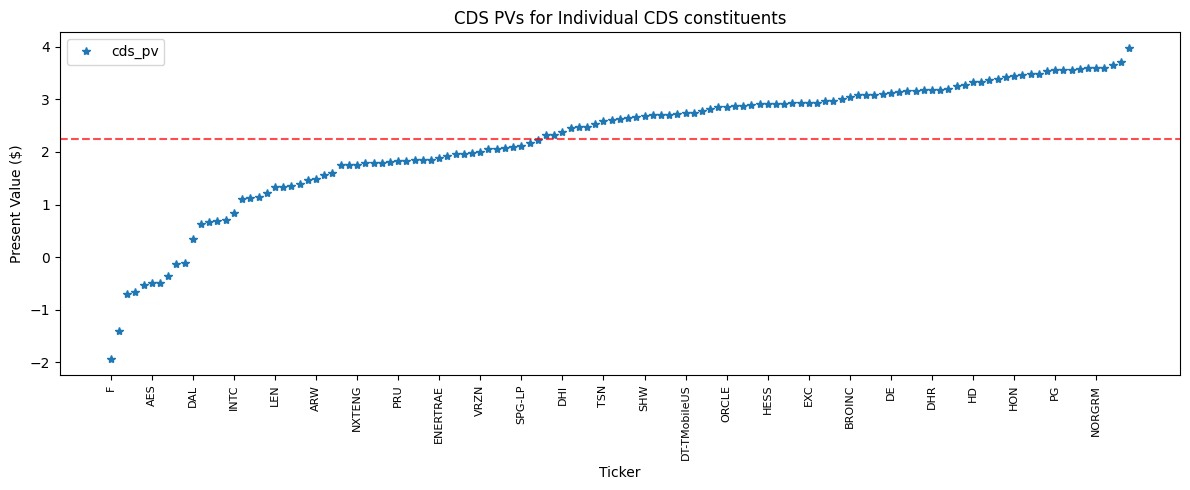

In [117]:
# Sort by PV
df_metrics = pd.DataFrame(metrics).sort_values(by='cds_pv')
display(df_metrics.head())

plt.figure(figsize=(12, 5))
plt.plot(df_metrics['ticker'], df_metrics['cds_pv'], '*', label='cds_pv')
plt.title('CDS PVs for Individual CDS constituents')
plt.xlabel('Ticker')
plt.xticks(ticks=range(0, len(df), 5), labels=df_metrics['ticker'][::5], rotation=90, fontsize=8)
plt.ylabel('Present Value ($)')
plt.axhline(cdx_pv, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

-----------------------------------------------------------
# Problem 4: PCA curve shape analysis of historical US SOFR OIS rates


## a. Load and explore US SOFR swaps extended symbology and market data

Load the `sofr_swap_symbology_ext` Excel file into a dataframe. List all available swap tenors.

Load the `sofr_swaps_market_data_eod_ext` Excel file into a dataframe. 

Plot the historial time series of SOFR rates for the available swap tenors.

In [ ]:
# sofr_swaps_symbology Dataframe
filepath_rawdata = f'./data/sofr_swaps_symbology_ext.xlsx'
sofr_swaps_symbology_ext = pd.read_excel(filepath_rawdata)
display(sofr_swaps_symbology_ext.head()) # show all tenors 

tenor_list = sofr_swaps_symbology_ext['tenor'].unique()
print(f"Available Swap Tenors: {tenor_list}")

# sofr_swaps_market_data_eod_ext Dataframe
filepath_rawdata = f'./data/sofr_swaps_market_data_eod_ext.xlsx'
sofr_swaps_market_data_eod_ext = pd.read_excel(filepath_rawdata)
display(sofr_swaps_market_data_eod_ext.head())

# Merge Data to give Tenor
merged_sofr_ext = pd.merge(sofr_swaps_symbology_ext, sofr_swaps_market_data_eod_ext, on=['figi'], how='inner')
display(merged_sofr_ext[['date', 'figi', 'ticker', 'tenor', 'midRate']].head())

,figi,ticker,class,bbg,name,tenor,type,dcc,exchange,country,currency,status
0,BBG00KFWPJJ9,USOSFR1,Curncy,USOSFR1 Curncy,USD OIS ANN VS SOFR 1Y,1,SWAP,ACT/360,NONE,US,USD,ACTV
1,BBG00KFWPJX3,USOSFR2,Curncy,USOSFR2 Curncy,USD OIS ANN VS SOFR 2Y,2,SWAP,ACT/360,NONE,US,USD,ACTV
2,BBG00KFWPK15,USOSFR3,Curncy,USOSFR3 Curncy,USD OIS ANN VS SOFR 3Y,3,SWAP,ACT/360,NONE,US,USD,ACTV
3,BBG00KFWPK33,USOSFR4,Curncy,USOSFR4 Curncy,USD OIS ANN VS SOFR 4Y,4,SWAP,ACT/360,NONE,US,USD,ACTV
4,BBG00KFWPK51,USOSFR5,Curncy,USOSFR5 Curncy,USD OIS ANN VS SOFR 5Y,5,SWAP,ACT/360,NONE,US,USD,ACTV


Available Swap Tenors: [ 1  2  3  4  5  6  7  8  9 10 12 15 20 25 30]


,date,figi,bidRate,askRate,midRate
0,2018-01-02,BBG00KFWPKD2,2.1232,2.1597,2.14145
1,2018-01-02,BBG00KFWPKF0,2.1386,2.2008,2.16970
2,2018-01-02,BBG00KFWPKG9,2.1579,2.1913,2.17460
3,2018-01-02,BBG00KFWPKH8,2.1220,2.2024,2.16220
4,2018-01-02,BBG00KFWPJJ9,1.6992,1.7450,1.72210


,date,figi,ticker,tenor,midRate
0,2018-01-02,BBG00KFWPJJ9,USOSFR1,1,1.72210
1,2018-01-03,BBG00KFWPJJ9,USOSFR1,1,1.73600
2,2018-01-04,BBG00KFWPJJ9,USOSFR1,1,1.75110
3,2018-01-05,BBG00KFWPJJ9,USOSFR1,1,1.75430
4,2018-01-08,BBG00KFWPJJ9,USOSFR1,1,1.74875


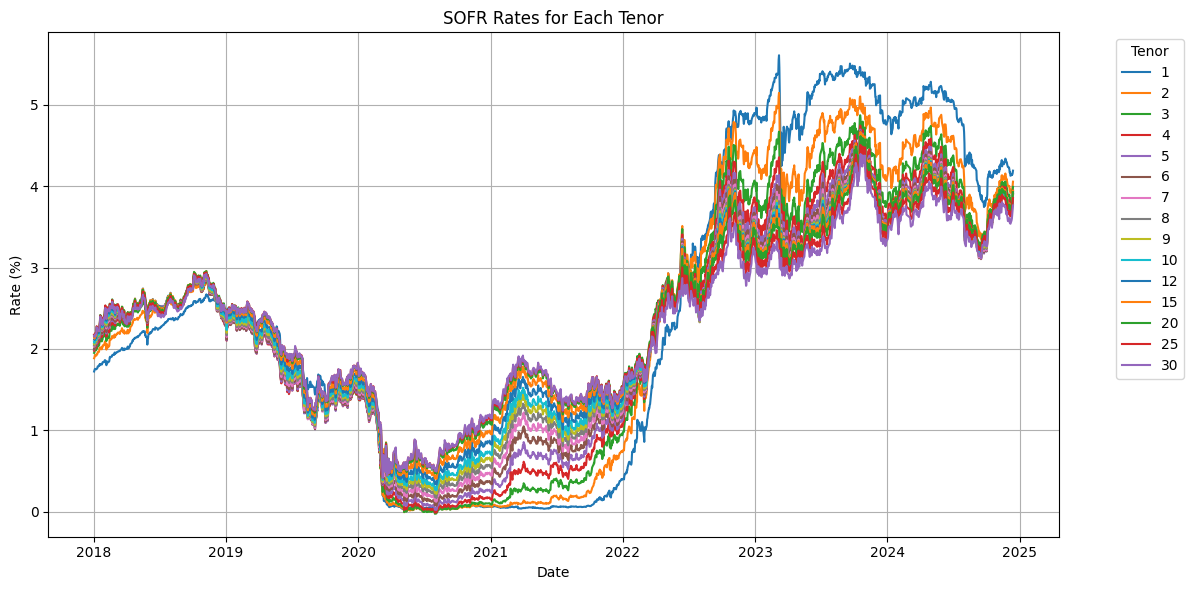

In [ ]:
plt.figure(figsize=(12, 6))

# Loop over each group
# variable: the unique value of the group
# group: the subset DataFrame of rows that belong to that group
for tenor, group in merged_sofr_ext.groupby('tenor'):
    plt.plot(group['date'], group['midRate'], label=tenor)

plt.xlabel("Date")
plt.ylabel("Rate (%)")
plt.title("SOFR Rates for Each Tenor")
plt.legend(title='Tenor', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## b. Run PCA analysis of SOFR OIS rate curves in level space

Run PCA analysis of SOFR OIS rates.

Display and plot the (factor loadings of the) first 3 principal components.

Extract the explained variance ratios for the first 5 principal components and add the cumulative explained variance ratio. Plot the results using a bar plot.

How much explanatory power is captured in the first 3 principal components?

Plot historical PCA scores (factor levels) forresponding to the first 3 principal components.

You can use PCA from sklearn.decomposition, or any other equivalent package.

In [ ]:
# PCA Analysis Prep: Dataframe has to have date as index, each column is values for each variable (e.g., year)

# Pivot the dataframe so each tenor has its own column of midRate
df_pivoted = merged_sofr_ext.reset_index().pivot(index='date', columns='tenor', values='midRate').dropna()
# Rename columns
# df_pivoted.columns = [f'SOFR_{int(col)}Y' for col in df_pivoted.columns]
display(df_pivoted.head())

tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
date,,,,,,,,,,,,,,,
2018-01-02,1.72210,1.8848,1.9501,1.9767,1.994,1.99690,2.03275,2.04515,2.0626,2.0827,2.11245,2.14145,2.16970,2.17460,2.16220
2018-01-04,1.75110,1.9182,1.9841,2.0147,2.028,2.02495,2.05340,2.06020,2.0732,2.0897,2.10880,2.13455,2.16040,2.16070,2.15390
2018-01-05,1.75430,1.9252,1.9951,2.0297,2.046,2.04235,2.07180,2.08000,2.0936,2.1101,2.13810,2.16005,2.18625,2.19315,2.17880
2018-01-08,1.74875,1.9168,1.9841,2.0187,2.038,2.03695,2.06770,2.07610,2.0904,2.1072,2.13430,2.16195,2.18635,2.19230,2.18040
2018-01-09,1.75710,1.9359,2.0141,2.0557,2.084,2.09150,2.12860,2.14250,2.1605,2.1807,2.20860,2.24210,2.27260,2.27830,2.26615


,1,2,3,4,5
Variation Explained,98.45%,1.25%,0.28%,0.01%,0.01%


,1,2,3,4,5
Cumulative Variation Explained,98.45%,99.70%,99.98%,99.99%,100.00%


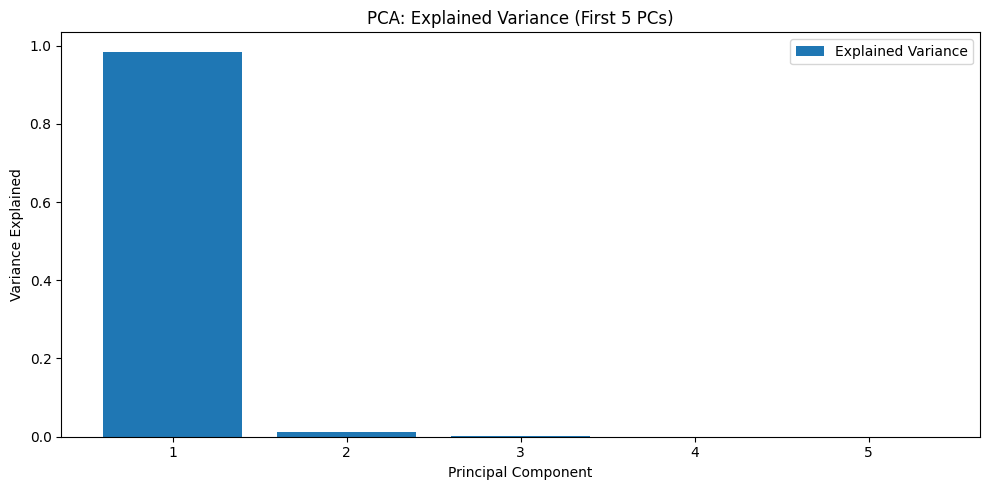

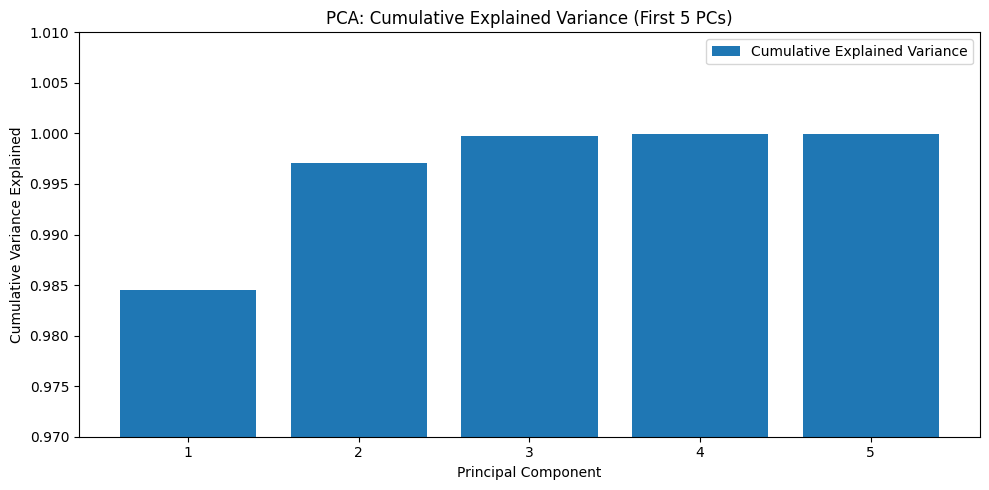

In [ ]:
# Extract the explained variance ratios for the first 5 principal components and add the cumulative explained variance ratio. 
# Plot the results using a bar plot.

# PCA Analysis

# Compute principal components using a full Singular Value Decomposition (SVD)
pca = PCA(svd_solver='full')
# Fits the PCA model to the dataset
pca.fit(df_pivoted)

# Make a new dataframe for the Variation Explained by each Principal Component
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_, columns=['Variation Explained']).T
pca_var_explained.columns = list(np.arange(1, 16, 1)) # Needs to be adjusted (num of columns + 1)
# display(pca_var_explained.style.format('{:.2%}'.format))

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
pca_cum_var_explained = pd.DataFrame(cumulative_variance, columns=['Cumulative Variation Explained']).T
pca_cum_var_explained.columns = list(np.arange(1, 16, 1)) #  Needs to be adjusted (num of columns + 1)
# display(pca_cum_var_explained.style.format('{:.2%}'.format))

# Show only the first 5 Principal Components
display(pca_var_explained.iloc[:, :5].style.format('{:.2%}'.format))
display(pca_cum_var_explained.iloc[:, :5].style.format('{:.2%}'.format))

# Bar Graph for pca_var_explained
x_axis_values = list(np.arange(1, 6))
y_axis_values = pca.explained_variance_ratio_[:5] # Not cumulative
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='Explained Variance')
plt.title('PCA: Explained Variance (First 5 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Graph for pca_cum_var_explained
x_axis_values = list(np.arange(1, 6))
y_axis_values = np.cumsum(pca.explained_variance_ratio_)[:5] # Cumulative
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance (First 5 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.ylim(0.97, 1.01)  # Start y-axis at certain level
plt.legend()
plt.tight_layout()
plt.show()

The first 3 principal components capture 99.98% explanatory power.

tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
PC_1,0.3710,0.3326,0.3038,0.2836,0.2688,0.2572,0.2480,0.2405,0.2346,0.2299,0.2231,0.2166,0.2068,0.1966,0.1879
PC_2,0.6351,0.3713,0.1843,0.0615,-0.0223,-0.0794,-0.1245,-0.1536,-0.1749,-0.1910,-0.2133,-0.2310,-0.2485,-0.2658,-0.2773
PC_3,0.5674,-0.1374,-0.3347,-0.3405,-0.2856,-0.2099,-0.1464,-0.0813,-0.0262,0.0158,0.0899,0.1699,0.2460,0.2861,0.3118


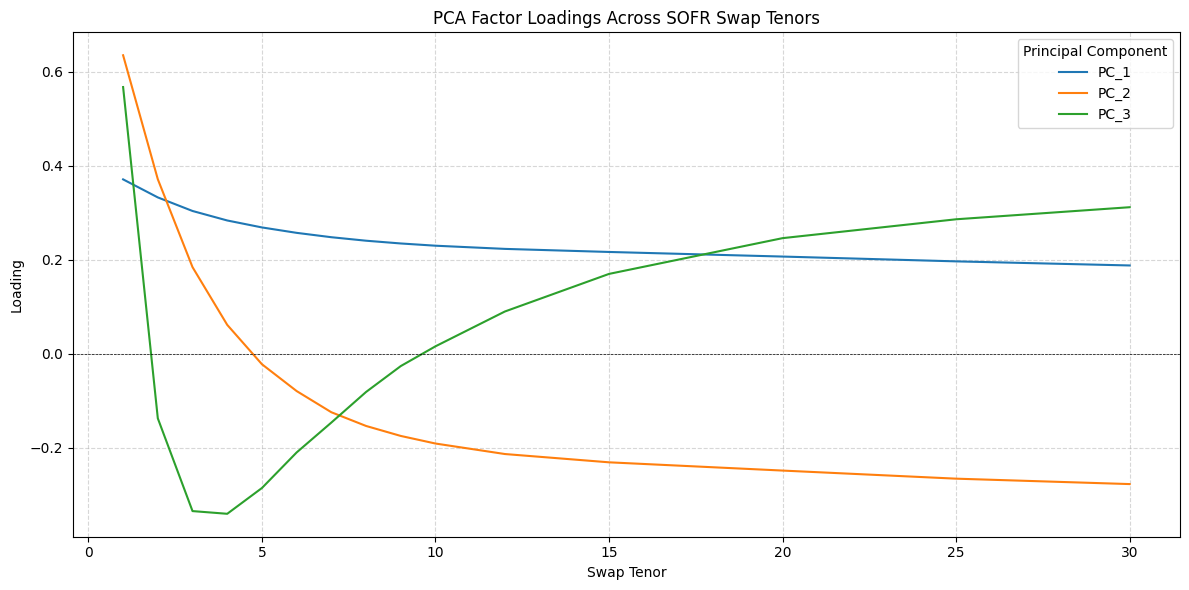

In [ ]:
# Display and plot the (factor loadings of the) first 3 principal components.

# Factor Loadings (use the appropriate dataframe)
pca_wts = pd.DataFrame(pca.components_, columns=df_pivoted.columns)
pca_wts.index = ['PC_1','PC_2','PC_3', 
                 'PC_4',
                 'PC_5',
                 'PC_6',
                 'PC_7',
                 'PC_8',
                 'PC_9',
                 'PC_10',
                 'PC_11',
                 'PC_12',
                 'PC_13',
                 'PC_14',
                 'PC_15',
                 ]

df_factor_loadings = pca_wts.head(3).style.format('{:.4f}')
display(df_factor_loadings)

# Take relevant PCs
df_factor_loadings = pca_wts.head(3)

plt.figure(figsize=(12, 6))
for index, row in df_factor_loadings.iterrows():
    plt.plot(df_factor_loadings.columns, row.values, label=index)

plt.title("PCA Factor Loadings Across SOFR Swap Tenors")
plt.xlabel("Swap Tenor")
plt.ylabel("Loading")
plt.xticks(rotation=0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--') # x axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Principal Component")
plt.tight_layout()
plt.show()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
date,,,,,,,,,,,,,,,
2018-01-02,7.644481,-1.916454,0.302525,0.235996,0.011923,-0.008073,-0.003055,0.003682,-0.000447,-0.005036,-0.002610,-0.009125,-0.000409,0.006016,-0.000815
2018-01-04,7.708121,-1.877415,0.259705,0.227325,-0.001862,-0.006963,0.002448,0.003488,-0.003892,-0.004637,-0.004148,-0.009533,0.000624,0.004615,-0.001960
2018-01-05,7.775808,-1.918508,0.268835,0.231123,-0.000563,-0.010176,0.000114,-0.001438,0.000082,-0.007401,-0.001429,-0.011493,0.000284,0.004785,-0.001292
2018-01-08,7.757301,-1.924895,0.278902,0.230330,0.001174,-0.008920,0.001916,-0.001975,-0.001747,-0.004929,-0.002900,-0.009777,-0.000306,0.004821,-0.000856
2018-01-09,7.961954,-2.056566,0.311655,0.235943,0.005192,-0.008022,0.003287,0.001553,-0.000379,-0.003791,-0.003871,-0.009008,0.000459,0.005505,-0.000327


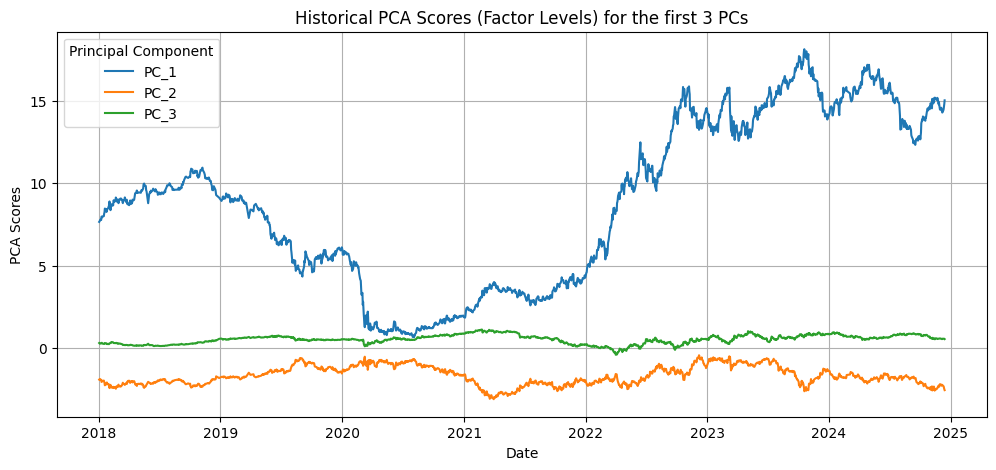

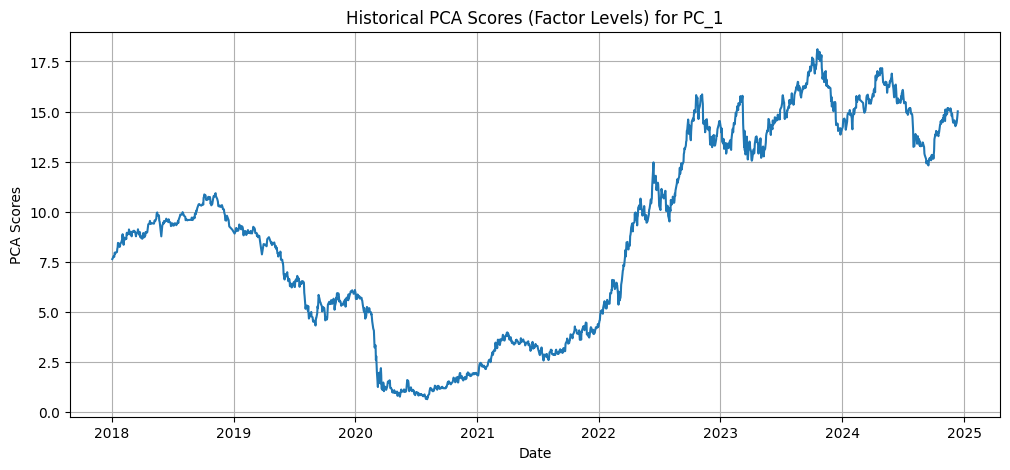

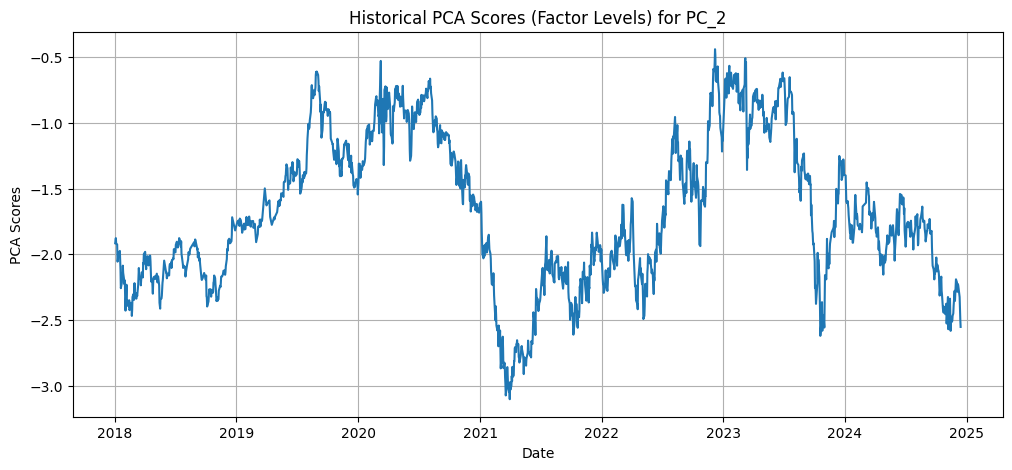

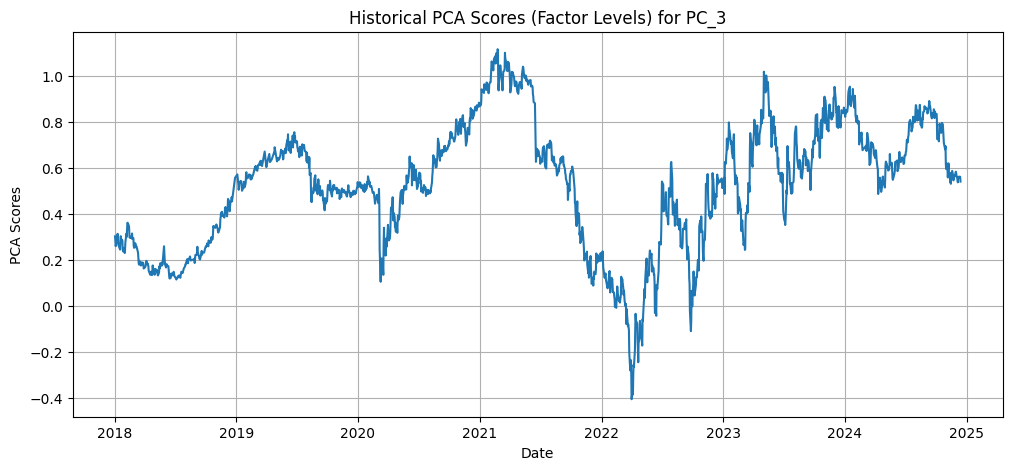

In [ ]:
# Historical PCA Scores (factor levels)

# PCA Factor Levels = Data x PCA Weights
df_PCA_factors = df_pivoted @ pca_wts.T
display(df_PCA_factors.head())

plt.figure(figsize=(12, 5))
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_1'], '-', label='PC_1')
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_2'], '-', label='PC_2')
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_3'], '-', label='PC_3')
plt.title(f'Historical PCA Scores (Factor Levels) for the first 3 PCs')
plt.xlabel('Date')
plt.ylabel('PCA Scores')
plt.legend(title="Principal Component")
plt.grid()
plt.show()

PC_list = ['PC_1', 'PC_2', 'PC_3']
for each_PC in PC_list:
    plt.figure(figsize=(12, 5))
    plt.plot(df_PCA_factors.index, df_PCA_factors[each_PC], '-', label=each_PC)
    plt.title(f'Historical PCA Scores (Factor Levels) for {each_PC}')
    plt.xlabel('Date')
    plt.ylabel('PCA Scores')
    plt.grid()
    plt.show()

## c. Run PCA analysis of SOFR OIS rate curves in (daily) differences space

Repeat the PCA analysis from b. in daily difference space.


In [ ]:
# Step 1: Prep the dataframe: Calculate daily differences
df_diff = df_pivoted.diff().dropna()
display(df_diff.head())

tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
date,,,,,,,,,,,,,,,
2018-01-04,0.02900,0.0334,0.034,0.038,0.034,0.02805,0.02065,0.01505,0.0106,0.0070,-0.00365,-0.00690,-0.00930,-0.01390,-0.00830
2018-01-05,0.00320,0.0070,0.011,0.015,0.018,0.01740,0.01840,0.01980,0.0204,0.0204,0.02930,0.02550,0.02585,0.03245,0.02490
2018-01-08,-0.00555,-0.0084,-0.011,-0.011,-0.008,-0.00540,-0.00410,-0.00390,-0.0032,-0.0029,-0.00380,0.00190,0.00010,-0.00085,0.00160
2018-01-09,0.00835,0.0191,0.030,0.037,0.046,0.05455,0.06090,0.06640,0.0701,0.0735,0.07430,0.08015,0.08625,0.08600,0.08575
2018-01-10,0.00100,-0.0027,-0.004,-0.007,-0.008,-0.00615,-0.00620,-0.00540,-0.0039,-0.0036,-0.00270,-0.00515,-0.00535,-0.00790,-0.00945


,1,2,3,4,5
Variation Explained,88.65%,8.88%,1.42%,0.31%,0.24%


,1,2,3,4,5
Cumulative Variation Explained,88.65%,97.52%,98.94%,99.25%,99.49%


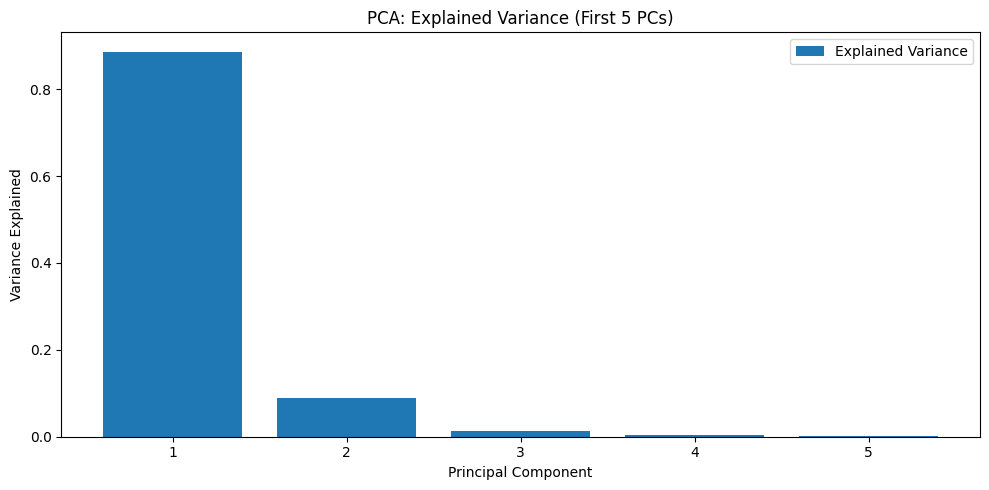

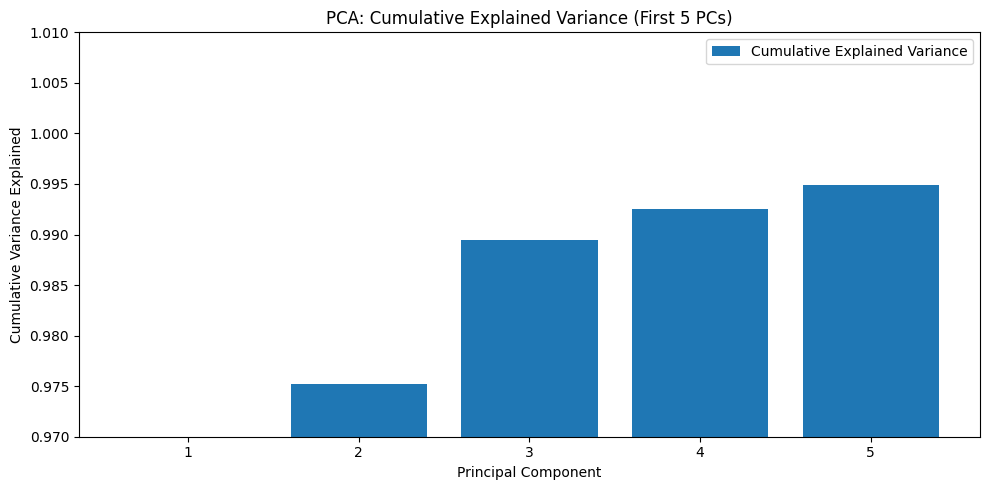

In [ ]:
# Extract the explained variance ratios for the first 5 principal components and add the cumulative explained variance ratio. 
# Plot the results using a bar plot.

# PCA Analysis

# Compute principal components using a full Singular Value Decomposition (SVD)
pca = PCA(svd_solver='full')
# Fits the PCA model to the dataset
pca.fit(df_diff)

# Make a new dataframe for the Variation Explained by each Principal Component
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_, columns=['Variation Explained']).T
pca_var_explained.columns = list(np.arange(1, 16, 1)) # Needs to be adjusted (num of columns + 1)
# display(pca_var_explained.style.format('{:.2%}'.format))

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
pca_cum_var_explained = pd.DataFrame(cumulative_variance, columns=['Cumulative Variation Explained']).T
pca_cum_var_explained.columns = list(np.arange(1, 16, 1)) #  Needs to be adjusted (num of columns + 1)
# display(pca_cum_var_explained.style.format('{:.2%}'.format))

# Show only the first 5 Principal Components
display(pca_var_explained.iloc[:, :5].style.format('{:.2%}'.format))
display(pca_cum_var_explained.iloc[:, :5].style.format('{:.2%}'.format))

# Bar Graph for pca_var_explained
x_axis_values = list(np.arange(1, 6))
y_axis_values = pca.explained_variance_ratio_[:5] # Not cumulative
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='Explained Variance')
plt.title('PCA: Explained Variance (First 5 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.tight_layout()
plt.show()

# Bar Graph for pca_cum_var_explained
x_axis_values = list(np.arange(1, 6))
y_axis_values = np.cumsum(pca.explained_variance_ratio_)[:5] # Cumulative
plt.figure(figsize=(10, 5))
plt.bar(x_axis_values, y_axis_values, label='Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance (First 5 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.ylim(0.97, 1.01)  # Start y-axis at certain level
plt.legend()
plt.tight_layout()
plt.show()

The first 3 principal components capture 98.94% explanatory power (for daily differences space)

tenor,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30
PC_1,0.1807,0.2474,0.2679,0.2764,0.2809,0.2813,0.2808,0.2765,0.2759,0.2724,0.2613,0.2512,0.2425,0.2310,0.2252
PC_2,0.4589,0.4587,0.3419,0.2255,0.1251,0.0487,-0.0103,-0.0556,-0.1028,-0.1358,-0.1797,-0.2308,-0.2729,-0.3083,-0.3253
PC_3,0.6220,0.2262,-0.0949,-0.2404,-0.2773,-0.2443,-0.2092,-0.1742,-0.1103,-0.0761,0.0118,0.1077,0.2030,0.3094,0.3433


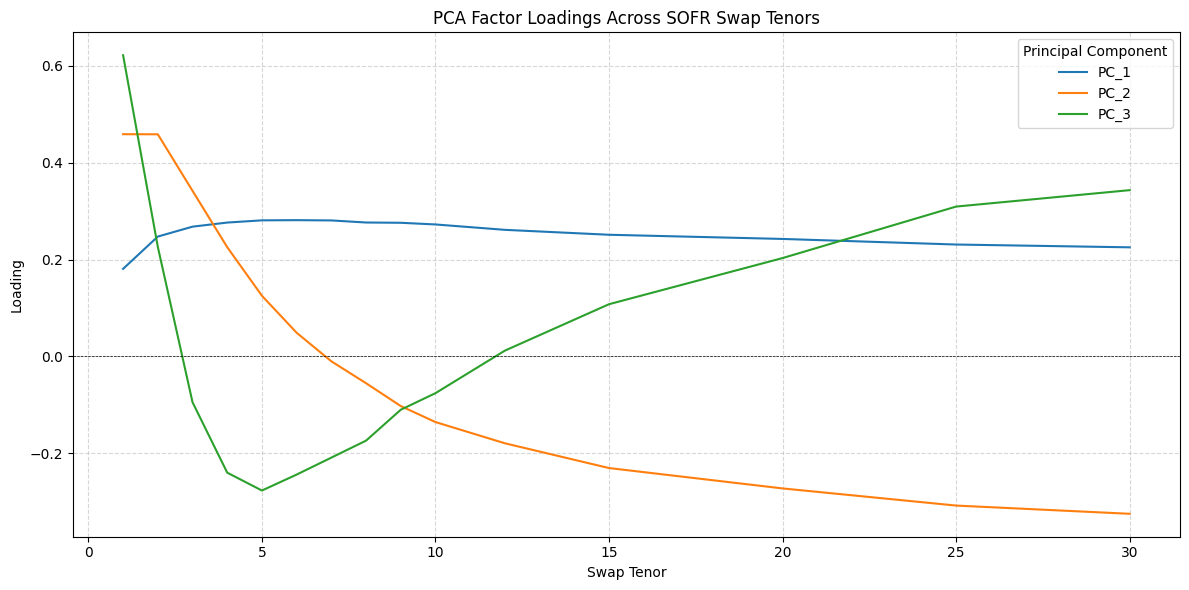

In [ ]:
# Display and plot the (factor loadings of the) first 3 principal components.

# Factor Loadings (use the appropriate dataframe)
pca_wts = pd.DataFrame(pca.components_, columns=df_diff.columns)
pca_wts.index = ['PC_1','PC_2','PC_3', 
                 'PC_4',
                 'PC_5',
                 'PC_6',
                 'PC_7',
                 'PC_8',
                 'PC_9',
                 'PC_10',
                 'PC_11',
                 'PC_12',
                 'PC_13',
                 'PC_14',
                 'PC_15',
                 ]

df_factor_loadings = pca_wts.head(3).style.format('{:.4f}')
display(df_factor_loadings)

# Take relevant PCs
df_factor_loadings = pca_wts.head(3)

plt.figure(figsize=(12, 6))
for index, row in df_factor_loadings.iterrows():
    plt.plot(df_factor_loadings.columns, row.values, label=index)

plt.title("PCA Factor Loadings Across SOFR Swap Tenors")
plt.xlabel("Swap Tenor")
plt.ylabel("Loading")
plt.xticks(rotation=0)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--') # x axis
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Principal Component")
plt.tight_layout()
plt.show()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
date,,,,,,,,,,,,,,,
2018-01-04,0.055328,0.063128,-0.021516,-0.001493,-0.009600,-0.006185,0.001275,-0.007561,0.003343,0.002204,0.001834,-0.001438,0.000328,-0.000422,-0.000845
2018-01-05,0.074615,-0.027547,0.005510,-0.000230,0.005986,-0.003713,0.003704,0.002873,0.003185,-0.000777,-0.001331,-0.001179,-0.001389,0.000661,0.000561
2018-01-08,-0.017065,-0.012966,0.004450,0.001849,-0.000331,0.002342,-0.001875,-0.003267,-0.000959,-0.000757,0.000764,0.001824,0.000846,0.000254,0.000099
2018-01-09,0.227231,-0.091703,0.017126,-0.001730,-0.000156,0.001518,-0.000978,0.001485,-0.002699,-0.002144,0.000234,0.001320,-0.001737,0.000104,-0.000064
2018-01-10,-0.020011,0.004872,0.001375,0.005123,0.000736,0.003980,-0.000384,0.003048,-0.001537,0.000044,-0.001338,0.001057,0.000569,-0.001073,-0.000375


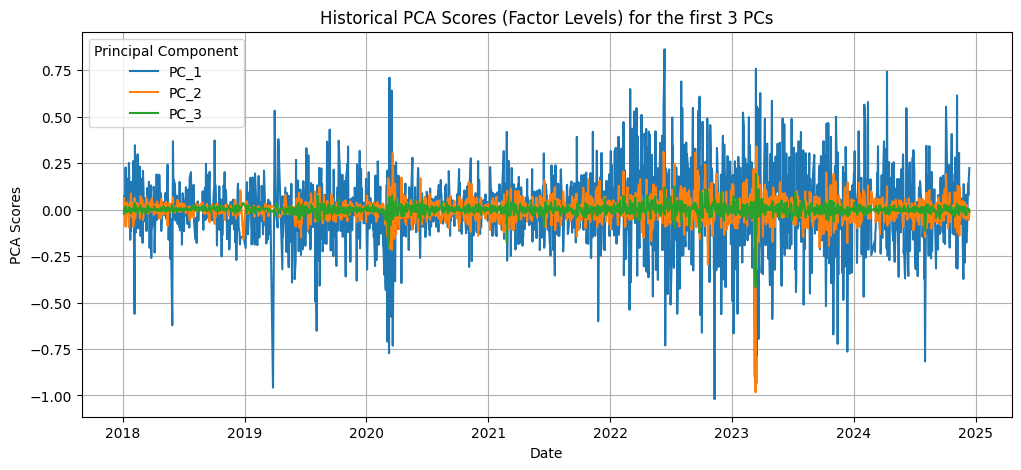

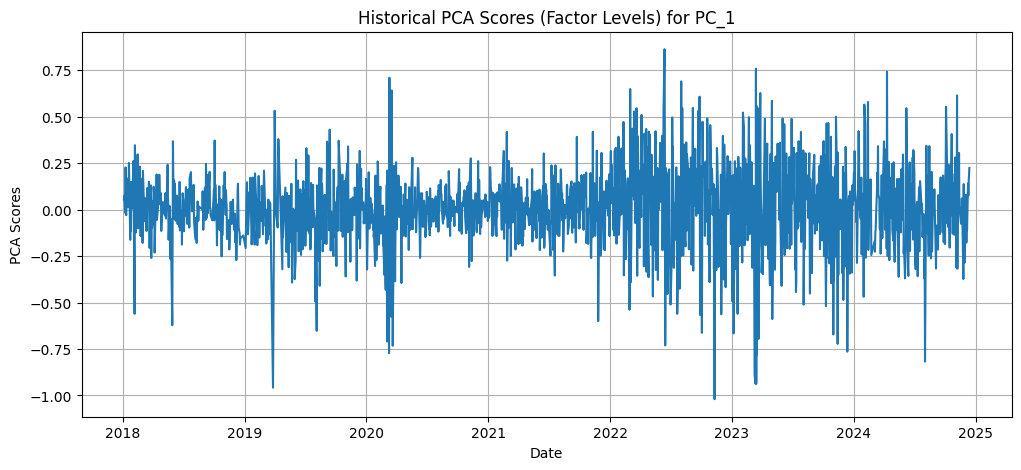

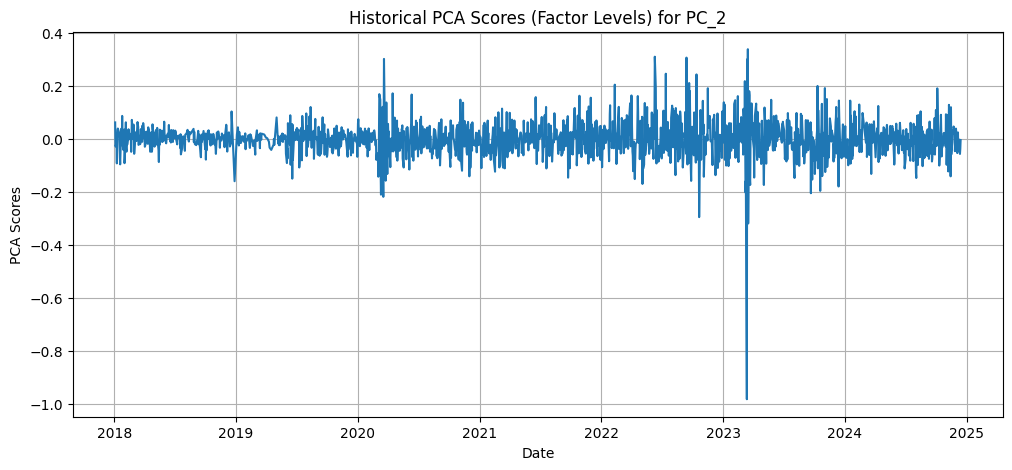

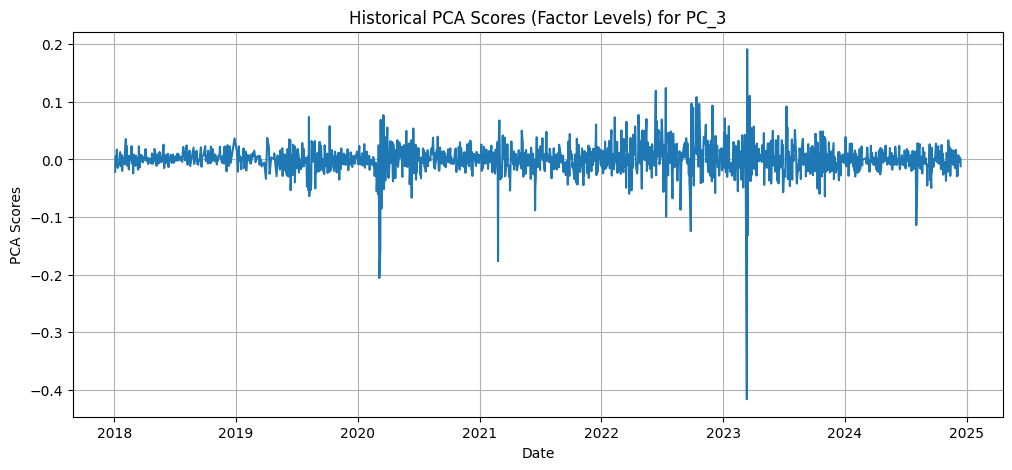

In [ ]:
# Historical PCA Scores

# PCA Factor Levels = Data x PCA Weights
df_PCA_factors = df_diff @ pca_wts.T
display(df_PCA_factors.head())

plt.figure(figsize=(12, 5))
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_1'], '-', label='PC_1')
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_2'], '-', label='PC_2')
plt.plot(df_PCA_factors.index, df_PCA_factors['PC_3'], '-', label='PC_3')
plt.title(f'Historical PCA Scores (Factor Levels) for the first 3 PCs')
plt.xlabel('Date')
plt.ylabel('PCA Scores')
plt.legend(title="Principal Component")
plt.grid()
plt.show()

PC_list = ['PC_1', 'PC_2', 'PC_3']
for each_PC in PC_list:
    plt.figure(figsize=(12, 5))
    plt.plot(df_PCA_factors.index, df_PCA_factors[each_PC], '-', label=each_PC)
    plt.title(f'Historical PCA Scores (Factor Levels) for {each_PC}')
    plt.xlabel('Date')
    plt.ylabel('PCA Scores')
    plt.grid()
    plt.show()

## d. Intuitive interpretation of PC1, PC2 and PC3 and connection to the Nelson-Siegel model

Identify and interpret the curve shapes of the top 3 first principal components. 

Do you see any connection to the Nelson-Siegel model curve shapes?

Yes, the first 3 principal components resemble the basis function shapes in the Nelson Siegel Model. 

From the graph for PCA Factor Loading across different Swap Tenors, we can observe that:
1. Principal Component 1: 
- The loadings are flat and positive across tenors. 
- This is the Level Factor, which captures parallel shift in the yield curve, i.e., movements where all rates rise or fall together. 
- It reflects changes in the overall level of interest rates. 
- Resembles theta_1, the level term in the Nelson-Siegel model

2. Principal Component 2: 
- The loadings decline steadily from short to long maturities.
- This is the Slope Factor, which captures the steeping or flattening behavior.
- It reflects the changes in the difference between short-term and long-term interest rates. 
- Resembles theta_2, the slope term in the Nelson-Siegel model

3. Principal Component 3: 
- The loadings show a dip - declining in the short end and then rising in the long end.
- This is the Curvature Factor, which captures changes in the curve's shape, such as humps or dips, particularly in the intermediate maturities. 
- Resembles theta_3, the curvature term in the Nelson-Siegel model

The majority of the variation in SOFR OIS rates is captured by PC 1, indicating that most daily movements in the curve are due to changes in the general interest rate level. 

The second most important factor, PC 2, captures the variations in the slope of the curve, the changes in the difference between short-term and long-term interest rates. 

### Solution

<i> Identify and interpret the curve shapes of the top 3 first principal components: </i>
- PC1: Represent the dominant "level" factor. Positive scores indicate days where all rates rose uniformly, negative scores indicate uniform declines.

- PC2: Reflect the "slope" factor. <br>
Positive scores suggest a steeper yield curve (short-term rates ↓, long-term rates ↑). <br>
Negative scores suggest a flatter yield curve (short-term rates ↑, long-term rates ↓). 

- PC3 Scores: Capture the "curvature" factor. Positive scores imply a "hump" (middle rates rise relative to short/long rates).


<i>  Do you see any connection to the Nelson-Siegel model curve shapes? </i>

PC1, PC2 and PC3 curve shapes correspond to the Level/Slope/Curvature curve shapes in the Nelson-Siegel model(up to a +/- sign).